# Predict to BITCOIN price/volume by Sentimental Analysis(NLP)
## create by Cline
----

### 필요모듈 import
- ekonlpy, konlpy, mecab ..

In [71]:
%cd /tmp

/private/tmp


In [72]:
!ls

FLEXnet                      eppclient.lock
com.apple.launchd.WzFiX9583o kav_delayed_start_stderr.log
com.google.Keystone          kav_delayed_start_stdout.log
epp-zc23.n501                powerlog
epp-zc239fd3


In [73]:
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   440k      0  0:00:03  0:00:03 --:--:--  863k


In [76]:
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 47.4M  100 47.4M    0     0  5145k      0  0:00:09  0:00:09 --:--:-- 8558k


In [8]:
!pip install ./eKoNLPy

Processing ./eKoNLPy
  Created wheel for eKoNLPy: filename=eKoNLPy-0.5.30-py3-none-any.whl size=14437139 sha256=7f654f71a9dbeeb5efed8020783ab08466af2d867f1bceabad93e20658726f2d
  Stored in directory: /private/var/folders/4s/k8xpx9gn0nn7mk_x4sks4b2c0000gn/T/pip-ephem-wheel-cache-izqhmy2t/wheels/72/d1/31/28526d0c046ba82ae7a93449810f252ecfd1a5c7db72ab0931
Successfully built eKoNLPy
  Attempting uninstall: eKoNLPy
    Found existing installation: eKoNLPy 0.5.30
    Uninstalling eKoNLPy-0.5.30:
      Successfully uninstalled eKoNLPy-0.5.30


In [ ]:
!sudo apt-get install g++ openjdk-7-jdk
!sudo apt-get install python-dev; pip install konlpy
!sudo apt-get install python3-dev; pip3 install konlpy
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
from io import StringIO
from io import open

import pandas as pd
import seaborn as sns
from krwordrank.word import KRWordRank
import numpy as np
from collections import defaultdict
import re
import requests

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from ekonlpy.sentiment import MPCK
mpck = MPCK()
from datetime import datetime, timedelta
from tqdm import tqdm

In [5]:
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

---
### 데이터 1 : 코인데스크코리아

In [7]:
# 2 method

def get_text(url):
    source_from_url = urllib.request.urlopen(url)
    soup = BeautifulSoup(source_from_url, 'lxml', from_encoding='utf-8')
    text = ''
    
    for item in soup.find_all('div', id='list_news'):
        text = text + str(item.find_all(text=True))
        
        return text

user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type(2) div.text-block p a

user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type(1) div.text-block p a


In [2]:
# main method

news_title = []
date_list = []
news_article = []

for i in tqdm(range(1, 303)):
    url = 'https://www.coindeskkorea.com/news/articleList.html?page={}&total=6048&box_idxno=&view_type=sm'.format(i)
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, 'html.parser')
    
    for j in range(1, 121):
        title = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-titles a strong'.format(j))
        date = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-dated'.format(j))
        article = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block p a'.format(j))
        
        news_title.append(title)
        date_list.append(date)
        news_article.append(article)
        
print("총 {}개의 전처리가 필요한 제목".format(len(news_title)))
print("총 {}개의 전처리가 필요한 날짜".format(len(date_list)))
print("총 {}개의 전처리가 필요한 기사".format(len(news_article)))

100%|██████████| 302/302 [10:07<00:00,  2.01s/it]

총 36240개의 전처리가 필요한 제목
총 36240개의 전처리가 필요한 날짜
총 36240개의 전처리가 필요한 기사


In [3]:
news_title[:7]

[[<strong>CME 이더리움 선물 상장은 왜 중요한가</strong>],
 [],
 [],
 [],
 [],
 [],
 [<strong>국내 암호화폐 거래소들, VASP 신고 막바지 준비</strong>]]

In [4]:
clear_title = []

for title in tqdm(news_title):
    for tit in title:
        for t in tit:
#             print(t)
            clear_title.append(t)
            
print("전처리 후 제목: {}".format(len(clear_title)))
clear_title[:10]

100%|██████████| 36240/36240 [00:00<00:00, 1555496.65it/s]

전처리 후 제목: 6040


['CME 이더리움 선물 상장은 왜 중요한가',
 '국내 암호화폐 거래소들, VASP 신고 막바지 준비',
 '가상자산사업자 신고, 이렇게 하면 된다',
 '러시아, 암호화폐 과세 추진',
 '2/18 아침브리핑: NFT를 왜 사야 하냐고요?',
 '나스닥 상장 채굴기 제조사, 직접 BTC 채굴 나서',
 '[시황] 비트코인 5만2천달러 돌파',
 "'코인베이스 기업가치 770억달러로 추산'",
 '2/17 오후브리핑: 실명계정, 가상자산사업자, 매뉴얼',
 '도지코인 현상과 암호화폐 규제의 미래']

In [5]:
normal_date = []

for date_ in tqdm(date_list):
    for date in date_:
        for d in date:
            normal_date.append(d)
            
normal_date = normal_date[1::2]
print("전처리 후 제목: {}".format(len(normal_date)))
normal_date[:10]

100%|██████████| 36240/36240 [00:00<00:00, 2008397.88it/s]

전처리 후 제목: 6040


[' 2021-02-18 18:15',
 ' 2021-02-18 17:50',
 ' 2021-02-18 16:46',
 ' 2021-02-18 10:11',
 ' 2021-02-18 10:04',
 ' 2021-02-18 09:35',
 ' 2021-02-18 09:21',
 ' 2021-02-18 09:12',
 ' 2021-02-17 19:17',
 ' 2021-02-17 18:17']

In [6]:
clear_date = []

for _date in normal_date:
    clear_date.append(_date[1:-6])
    
clear_date[:5]

['2021-02-18', '2021-02-18', '2021-02-18', '2021-02-18', '2021-02-18']

In [7]:
source = []

for news in tqdm(news_article):
    for new in news:
        for nw in new:
            source.append(nw)
            
print(len(source))
print(source[:5])


clear_article = []

for i in tqdm(source):
    clear_article.append(i[6:-5])

print("전처리 후 제목: {}".format(len(clear_article)))
clear_article[:5]

100%|██████████| 6040/6040 [00:00<00:00, 967004.97it/s]

6040
['\n\t\t\t\t\t암호화폐 관심이 있는 독자라면 아마도 이 기사를 읽기 전에 이더리움 선물 관련 뉴스를 여러 차례 봤을 것이다. 시카고상품거래소(CME)에서 선물 거래가 시작된 지난 8일 이더리움 2월물 개통가는 1669.75달러였다. 같은 시각 이더리움 현물 가격은 1600달러 부근이었다. 그로부터 2주 채도 안 된 18일 기준 2월물 개통가는 1747.75달러까지 올랐으며 이더 현물 가격은 1800달러를 돌파했다. 이더 선물의 첫 주간 거래량은 1억6천만달러를 넘어섰다. 팀 맥코트 CME 매니징디렉터는 이더리움 선물은 성공적으로 출시됐으나 금융\t\t\t\t\t', '\n\t\t\t\t\t금융위원회와 금융감독원이 17일 특정 금융거래 정보의 이용 및 보고에 관한 법률(특금법) 감독규정 개정안을 입법 예고하고 가상자산사업자(VASP) 신고 매뉴얼을 공개한 가운데, 국내 암호화폐 거래소들이 VASP 신고를 위한 막바지 준비에 한창이다. 기존에 은행으로부터 실명 확인 입출금계정을 발급받은 업비트, 빗썸, 코인원, 코빗 등 4대 거래소는 내달 25일 접수가 시작되면 바로 신고 서류를 금융정보분석원(FIU)에 제출할 수 있도록 만반의 준비를 한 모양새다. 업비트 관계자는 "사전에 예고된 만큼 그동안 착실히 준비해 왔다"면서,\t\t\t\t\t', "\n\t\t\t\t\t정부가 내달 25일부터 시행되는 특금법 개정안을 앞두고, 가상자산사업자(VASP) 신고 매뉴얼을 17일 공개했다.특금법 개정안에 따르면, 암호화폐 거래소나 지갑 서비스 등 암호화폐를 이용한 영업을 하기 위해서는 가상자산사업자 신고수리를 받아야 한다.가상자산사업자 신고수리를 위한 대표적인 요건으로는 △정보보호 관리체계 인증(ISMS) △실명확인 입출금계정(실명계정) △대표자 및 임원의 자격요건 구비 등이 있다.국내에서 처음 시행되는 가상자산사업자 신고 매뉴얼에 대한 주요 내용을 살펴봤다. 1. 가상자산사업자에 해당하는 경우는?개정 '\t\t\t\t\t", '\n\t\t\t\t\t러시아 

['암호화폐 관심이 있는 독자라면 아마도 이 기사를 읽기 전에 이더리움 선물 관련 뉴스를 여러 차례 봤을 것이다. 시카고상품거래소(CME)에서 선물 거래가 시작된 지난 8일 이더리움 2월물 개통가는 1669.75달러였다. 같은 시각 이더리움 현물 가격은 1600달러 부근이었다. 그로부터 2주 채도 안 된 18일 기준 2월물 개통가는 1747.75달러까지 올랐으며 이더 현물 가격은 1800달러를 돌파했다. 이더 선물의 첫 주간 거래량은 1억6천만달러를 넘어섰다. 팀 맥코트 CME 매니징디렉터는 이더리움 선물은 성공적으로 출시됐으나 금융',
 '금융위원회와 금융감독원이 17일 특정 금융거래 정보의 이용 및 보고에 관한 법률(특금법) 감독규정 개정안을 입법 예고하고 가상자산사업자(VASP) 신고 매뉴얼을 공개한 가운데, 국내 암호화폐 거래소들이 VASP 신고를 위한 막바지 준비에 한창이다. 기존에 은행으로부터 실명 확인 입출금계정을 발급받은 업비트, 빗썸, 코인원, 코빗 등 4대 거래소는 내달 25일 접수가 시작되면 바로 신고 서류를 금융정보분석원(FIU)에 제출할 수 있도록 만반의 준비를 한 모양새다. 업비트 관계자는 "사전에 예고된 만큼 그동안 착실히 준비해 왔다"면서,',
 "정부가 내달 25일부터 시행되는 특금법 개정안을 앞두고, 가상자산사업자(VASP) 신고 매뉴얼을 17일 공개했다.특금법 개정안에 따르면, 암호화폐 거래소나 지갑 서비스 등 암호화폐를 이용한 영업을 하기 위해서는 가상자산사업자 신고수리를 받아야 한다.가상자산사업자 신고수리를 위한 대표적인 요건으로는 △정보보호 관리체계 인증(ISMS) △실명확인 입출금계정(실명계정) △대표자 및 임원의 자격요건 구비 등이 있다.국내에서 처음 시행되는 가상자산사업자 신고 매뉴얼에 대한 주요 내용을 살펴봤다. 1. 가상자산사업자에 해당하는 경우는?개정 '",
 '러시아 연방 정부가 암호화폐 과세를 추진한다.러시아 하원 격인 국가 두마(State Duma)는 성명서를 통해 러시아 연방 정부가 제안한 암호화폐 과세

In [10]:
date = pd.DataFrame(clear_date)
title = pd.DataFrame(clear_title)
article = pd.DataFrame(clear_article)

corpus = pd.concat([date, title, article], axis=1)
corpus.columns = ['timestamp', 'title', 'article']
corpus

,timestamp,title,article
0,2021-01-25,"영국 중앙은행 총재, 다보스 포럼서 디지털 화폐 논한다",영국 중앙은행인 잉글랜드은행(Bank of England)의 앤드류 베일리 총재와 ...
1,2021-01-25,"테마섹, 싱가포르 증권거래소와 디지털자산 사업 본격화","2160억달러(약 239조원) 규모의 자산을 운용하는 것으로 알려진, 싱가포르 2대..."
2,2021-01-25,중국 베이징·상하이시도 디지털 위안 실험,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글..."
3,2021-01-25,"코인베이스 ""보유 자산 900억달러 넘어""",2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...
4,2021-01-25,또 다시 나타난 가짜 비트코인 창시자,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...
...,...,...,...
6035,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...
6036,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ..."
6037,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...
6038,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ..."


In [18]:
# corpus.to_csv('corpus.csv')

### 데이터 2 : 네이버 뉴스

'https://search.naver.com/search.naver?&where=news&query=%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds=2018.03.01&de=2021.01.22&docid=&nso=so:r,p:from20180301to20210122,a:all&mynews=0&cluster_rank=46&start={}&refresh_start=0'.format(i)

In [15]:
# main method

naver_title = []
naver_date = []
naver_article = []

for i in tqdm(range(1, 303)):
    url = 'https://search.naver.com/search.naver?&where=news&query=%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds=2018.03.01&de=2021.01.22&docid=&nso=so:r,p:from20180301to20210122,a:all&mynews=0&cluster_rank=46&start={}&refresh_start=0'.format(i)
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, 'html.parser')
    
    for j in range(1, 21):
        title = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-titles a strong'.format(j))
        date = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-dated'.format(j))
        article = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block p a'.format(j))
        
        news_title.append(title)
        date_list.append(date)
        news_article.append(article)
        
print("총 {}개의 전처리가 필요한 제목".format(len(news_title)))
print("총 {}개의 전처리가 필요한 날짜".format(len(date_list)))
print("총 {}개의 전처리가 필요한 기사".format(len(news_article)))

100%|██████████| 302/302 [06:20<00:00,  1.26s/it]

총 42280개의 전처리가 필요한 제목
총 42280개의 전처리가 필요한 날짜
총 42280개의 전처리가 필요한 기사


---

### 비트코인 가격 수집

In [20]:
start_date = datetime.strptime('2018-03-14', '%Y-%m-%d')
end_date = datetime.strptime('2021-01-22', '%Y-%m-%d')

str_date_list = []

while start_date.strftime('%Y-%m-%d') != end_date.strftime('%Y-%m-%d'):
    str_date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date += timedelta(days=1)

whole = pd.DataFrame(str_date_list, columns=['date'])
whole

,date
0,2018-03-14
1,2018-03-15
2,2018-03-16
3,2018-03-17
4,2018-03-18
...,...
1040,2021-01-17
1041,2021-01-18
1042,2021-01-19
1043,2021-01-20


In [11]:
bitcoin = pd.read_csv('/Users/cline_local/python_develop/Analysis/bitcoin_price.csv')
bitcoin.columns = ['datetimes', 'price']
# bitcoin = bitcoin.sort_values(by='datetimes', ascending=False)
bitcoin

,datetimes,price
0,2018-03-18,8227500.0
1,2018-03-19,9436500.0
2,2018-03-20,9432000.0
3,2018-03-21,10012500.0
4,2018-03-22,9505500.0
...,...,...
1036,2021-01-17,38714500.0
1037,2021-01-18,39898500.0
1038,2021-01-19,40196000.0
1039,2021-01-20,38701000.0


### 데이터 형태 맞춰주기

In [12]:
corpus.columns = ['datetimes', 'title', 'article']
corpus

,datetimes,title,article
0,2021-01-25,"영국 중앙은행 총재, 다보스 포럼서 디지털 화폐 논한다",영국 중앙은행인 잉글랜드은행(Bank of England)의 앤드류 베일리 총재와 ...
1,2021-01-25,"테마섹, 싱가포르 증권거래소와 디지털자산 사업 본격화","2160억달러(약 239조원) 규모의 자산을 운용하는 것으로 알려진, 싱가포르 2대..."
2,2021-01-25,중국 베이징·상하이시도 디지털 위안 실험,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글..."
3,2021-01-25,"코인베이스 ""보유 자산 900억달러 넘어""",2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...
4,2021-01-25,또 다시 나타난 가짜 비트코인 창시자,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...
...,...,...,...
6035,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...
6036,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ..."
6037,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...
6038,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ..."


In [13]:
merged = pd.merge(corpus, bitcoin, how='left')
merged = merged.fillna(method='ffill')
merged

,datetimes,title,article,price
0,2021-01-25,"영국 중앙은행 총재, 다보스 포럼서 디지털 화폐 논한다",영국 중앙은행인 잉글랜드은행(Bank of England)의 앤드류 베일리 총재와 ...,NaN
1,2021-01-25,"테마섹, 싱가포르 증권거래소와 디지털자산 사업 본격화","2160억달러(약 239조원) 규모의 자산을 운용하는 것으로 알려진, 싱가포르 2대...",NaN
2,2021-01-25,중국 베이징·상하이시도 디지털 위안 실험,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글...",NaN
3,2021-01-25,"코인베이스 ""보유 자산 900억달러 넘어""",2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...,NaN
4,2021-01-25,또 다시 나타난 가짜 비트코인 창시자,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...,NaN
...,...,...,...,...
6035,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...,9436500.0
6036,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ...",9436500.0
6037,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...,9436500.0
6038,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ...",9436500.0


In [43]:
merged = merged[['datetimes', 'title', 'article', 'price']]
merged = merged.dropna(axis=0)
merged['price'] = merged['price'].astype(int)
merged

,datetimes,title,article,price
21,2021-01-21,"1/21 오후브리핑: 조진석, 국민은행, 바이든, 블랙록","KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...",35432500
22,2021-01-21,"한화 드림인 블록체인 해커톤, 최우수상 2팀 선정","한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...",35432500
23,2021-01-21,"바이든 대통령, 통화금융청장(OCC)에 리플 전 임원 임명 유력",미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,35432500
24,2021-01-21,"업비트, 싱가포르·인니 이어 타이(태국) 시장 진출",암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,35432500
25,2021-01-21,"코빗, UNI·YFI 상장… 디파이 토큰 확대",상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,35432500
...,...,...,...,...
6035,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...,9436500
6036,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ...",9436500
6037,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...,9436500
6038,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ...",9436500


In [15]:
# merged.to_csv('merged.csv')

---

### 상승률 및 하락률 만들어주기  
(하루 단위로 할지? 일주일로 할지? 한달로 할지?)  
우선 하루 단위로 진행

In [16]:
bitcoin_a = bitcoin.loc[:][:][:-1]
bitcoin_b = bitcoin.loc[:][:][1:].rename({'date':'1일 전 date', 'price':'1일 전 price'}, axis='columns').reset_index(drop=True)

In [95]:
total_price = pd.merge(bitcoin_a, bitcoin_b, left_index=True, right_index=True)

total_price['price'] = total_price['price'].astype(int)
total_price['1일 전 price'] = total_price['1일 전 price'].astype(int)
total_price.columns = ['day-1', 'price-1', 'day', 'price']
total_price

,day-1,price-1,day,price
0,2018-03-18,8227499,2018-03-19,9436500
1,2018-03-19,9436500,2018-03-20,9432000
2,2018-03-20,9432000,2018-03-21,10012500
3,2018-03-21,10012500,2018-03-22,9505500
4,2018-03-22,9505500,2018-03-23,9494500
...,...,...,...,...
1035,2021-01-16,40686000,2021-01-17,38714500
1036,2021-01-17,38714500,2021-01-18,39898500
1037,2021-01-18,39898500,2021-01-19,40196000
1038,2021-01-19,40196000,2021-01-20,38701000


In [88]:
# total_price.to_csv('total_price.csv')

In [18]:
total_price['labeling'] = np.where(total_price['price'] > total_price['price-1'], 'up',
                                  np.where(total_price['price'] == total_price['price-1'], '-',
                                          'down'))

In [19]:
datelabel = ['price', 'labeling']
price_labeling = total_price[datelabel]
price_labeling

,price,labeling
0,9436500,up
1,9432000,down
2,10012500,up
3,9505500,down
4,9494500,down
...,...,...
1035,38714500,down
1036,39898500,up
1037,40196000,up
1038,38701000,down


In [45]:
dataframe = pd.merge(merged, price_labeling, how='left')
dataframe.dropna(axis=0)

,datetimes,title,article,price,labeling
0,2021-01-21,"1/21 오후브리핑: 조진석, 국민은행, 바이든, 블랙록","KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...",35432500,down
1,2021-01-21,"한화 드림인 블록체인 해커톤, 최우수상 2팀 선정","한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...",35432500,down
2,2021-01-21,"바이든 대통령, 통화금융청장(OCC)에 리플 전 임원 임명 유력",미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,35432500,down
3,2021-01-21,"업비트, 싱가포르·인니 이어 타이(태국) 시장 진출",암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,35432500,down
4,2021-01-21,"코빗, UNI·YFI 상장… 디파이 토큰 확대",상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,35432500,down
...,...,...,...,...,...
6354,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...,9436500,up
6355,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ...",9436500,up
6356,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...,9436500,up
6357,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ...",9436500,up


In [46]:
# dataframe.to_csv('dataframe.csv')

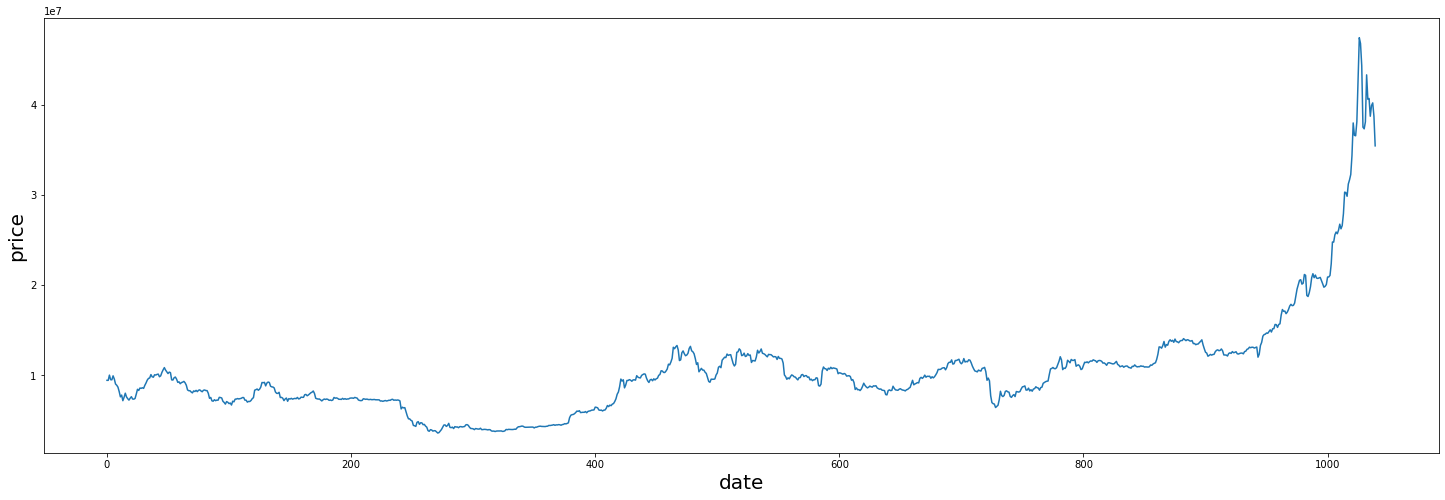

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))
plt.plot(price_labeling['price'])
plt.xlabel('date', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.show()

In [89]:
# price_labeling.to_csv('price_labeling.csv')

---

### 데이터 전처리(Tokenize) / Corpus 구축(N-gram, Stemming, Lemmatization)
Mecab or Khaiii?

In [286]:
# Sentimental Analysis를 한다면 data imbalance문제는 없음.

dataframe['labeling'].value_counts()

up      3434
down    2922
-          3
Name: labeling, dtype: int64

In [55]:
dataframe = dataframe.dropna(axis=0)
dataframe

,datetimes,title,article,price,labeling
0,2021-01-21,"1/21 오후브리핑: 조진석, 국민은행, 바이든, 블랙록","KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...",35432500,down
1,2021-01-21,"한화 드림인 블록체인 해커톤, 최우수상 2팀 선정","한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...",35432500,down
2,2021-01-21,"바이든 대통령, 통화금융청장(OCC)에 리플 전 임원 임명 유력",미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,35432500,down
3,2021-01-21,"업비트, 싱가포르·인니 이어 타이(태국) 시장 진출",암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,35432500,down
4,2021-01-21,"코빗, UNI·YFI 상장… 디파이 토큰 확대",상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,35432500,down
...,...,...,...,...,...
6354,2018-03-15,“가상통화 규제 반대” “강력 규제”…청와대 게시판도 시끌,‘규제 반대·금융위원장 등 해임 요구’ 국민청원 1만명 육박“일확천금 노리는 투기자...,9436500,up
6355,2018-03-15,가상통화로 스키렌탈·숙박 길 열렸다,"체인파트너스, ‘코인덕’ 서비스 출시오프라인 매장서 이더리움으로 결제결제 대기시간 ...",9436500,up
6356,2018-03-15,"김동연 “가상통화, 투기 부작용 있지만 산업혁명 성격”",21일 출입기자단과 송년 간담회“내년 1월 EU 조세 비협조지역 제외” 김동연 부...,9436500,up
6357,2018-03-15,정보보호 인증 등 가상화폐 거래소 보안대책 나왔지만…,"정부, ‘유빗’ 파산에 보안강화 대책 내놔빗썸, 코인원 등 정보보호 인증 조속이행 ...",9436500,up


In [347]:
# khaiii 반복문을 통한 형태소 분석 불가
# Mecab만 사용하지 않고, ekonlpy.tag MPCK 분석기 사용(필요시 Mecab도 사용)
from khaiii import KhaiiiApi
api = KhaiiiApi()

def n_tokenize(data_article):
    morphs = []
    
    for sentence in tqdm(data_article['article']):
        for word in api.analyze(sentence):
            for morph in word.morphs:
                morphs.append((morph.lex, morph.tag))

In [230]:
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
This script require Homebrew!
Try https://brew.sh/


---
# Check Point(read_csv)

In [9]:
total_dataframe = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/price_article.csv')
total_dataframe = total_dataframe[['datetimes', 'title', 'article', 'price']]
total_dataframe

,datetimes,title,article,price
0,2021-01-21,"1/21 오후브리핑: 조진석, 국민은행, 바이든, 블랙록","KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...",35432500.0
1,2021-01-21,"한화 드림인 블록체인 해커톤, 최우수상 2팀 선정","한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...",35432500.0
2,2021-01-21,"바이든 대통령, 통화금융청장(OCC)에 리플 전 임원 임명 유력",미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,35432500.0
3,2021-01-21,"업비트, 싱가포르·인니 이어 타이(태국) 시장 진출",암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,35432500.0
4,2021-01-21,"코빗, UNI·YFI 상장… 디파이 토큰 확대",상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,35432500.0
...,...,...,...,...
6024,2018-03-15,"금융위, 금융 아닌 유사수신 간주 “암호화폐 공인해줄 수 없다”",정부·중앙은행 지급보증 안해하루 거래량 코스닥 압도 소비자보호 장치 등 마련중 비트...,9436500.0
6025,2018-03-14,12월부터 실손보험금 ‘블록체인’으로 편리하게,"과기정통부, 교보생명과 손잡고수원 가톨릭병원 등 3개 병원 시행블록체인 기술로 스마...",9436500.0
6026,2018-03-14,새 암호화폐 프레스코인 아시나요,영국 기자 아흐메드 등“탐사보도 지원하겠다22일부터 1코인 1달러 발행” 탐사보도...,9436500.0
6027,2018-03-14,“ICO 전면금지…4차 산업혁명 싹 자르는 꼴”,국내 첫 블록체인 전공과정 개설한 박수용 서강대 교수“암호화폐뿐 아니라 신뢰 필요한...,9436500.0


In [10]:
# total_dataframe을 source 사용

date_article = total_dataframe[['datetimes', 'article']]
date_article['article'] = date_article['article'].astype(str)
date_article

<ipython-input-10-addbf7607253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_article['article'] = date_article['article'].astype(str)


,datetimes,article
0,2021-01-21,"KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT..."
1,2021-01-21,"한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특..."
2,2021-01-21,미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...
3,2021-01-21,암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...
4,2021-01-21,상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...
...,...,...
6024,2018-03-15,정부·중앙은행 지급보증 안해하루 거래량 코스닥 압도 소비자보호 장치 등 마련중 비트...
6025,2018-03-14,"과기정통부, 교보생명과 손잡고수원 가톨릭병원 등 3개 병원 시행블록체인 기술로 스마..."
6026,2018-03-14,영국 기자 아흐메드 등“탐사보도 지원하겠다22일부터 1코인 1달러 발행” 탐사보도...
6027,2018-03-14,국내 첫 블록체인 전공과정 개설한 박수용 서강대 교수“암호화폐뿐 아니라 신뢰 필요한...


---
##### 현재 Mac단말기에서 Mecab 구동이 잘 안되므로, Colab에서 형태소분석을 실행 후 corpus.csv 형태로 붙여준다.
---
filename : eKoNLPy.tag_sentimental_mpck

In [6]:
pos_tagger = []
pos_ngram_tagger = []
pos_score = []

for sentence in tqdm(date_article['article']):
    tokens = mpck.tokenize(sentence)
    if tokens != []:
    ngrams = mpck.ngramize(tokens)
    score = mpck.classify(tokens + ngrams, intensity_cutoff=1.3) # hyperparameters 설정이 필요함. 어조분류 score <- 추후, 결과 및 논의를 통해서 수정 요망(cline)
    
    pos_tagger.append(tokens)
    pos_ngram_tagger.append(ngrams)
    pos_score.append(score)
    
print(len(pos_tagger), len(pos_ngram_tagger), len(pos_score))

SyntaxError: invalid syntax (<ipython-input-6-3d46eb53e98a>, line 7)

In [40]:
pos_tagger[:1][0][0]

'암호화폐/NNG'

---

### 형태소 분석 후 사용할 품사 지정 : 명사 / 대명사 / 동사 / 형용사 / 부사

In [7]:
df_pos_tagger = pd.DataFrame(pos_tagger)
df_pos_ngram_tagger = pd.DataFrame(pos_ngram_tagger)
df_pos_score = pd.DataFrame(pos_score)

NameError: name 'pos_tagger' is not defined

In [33]:
df = pd.concat([df_pos_tagger, df_pos_ngram_tagger, df_pos_score], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,Polarity,Intensity,Pos score,Neg score
0,암호화폐/NNG,트래블/NNG,룰/NNG,화이트리스트/NNG,해결/NNG,가능/NNG,조진/NNG,석/NNG,기술혁신/NNG,트래블/NNG,...,None,None,None,None,None,None,-0.999957,44416.351492,0.000022,0.999978
1,드림/NNG,블록체인/NNG,해커톤/NNG,결선/NNG,수상/NNG,팀/NNG,우수/NNG,팀/NNG,라인/NNG,특별상/NNG,...,None,None,None,None,None,None,-0.991064,222.761269,0.004468,0.995532
2,경제/NNG,일간지/NNG,리플/NNG,이자/NNG,미/NNG,역임/NNG,하/VV,미시간대/NNG,스쿨/NNG,공공/NNG,...,None,None,None,None,None,None,0.813074,9.699296,0.906537,0.093463
3,암호화폐/NNG,거래소/NNG,업/NNG,비트/NNG,시장/NNG,진출/NNG,하/VV,업/NNG,비트/NNG,운영사/NNG,...,None,None,None,None,None,None,-0.982288,111.904431,0.008856,0.991144
4,상장/NNG,심사/NNG,엄격/NNG,암호화폐/NNG,거래소/NNG,코/NNG,토큰/NNG,확대/NNG,나서/VV,인기/NNG,...,None,None,None,None,None,None,-0.998271,1154.149909,0.000865,0.999135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024,지급보증/NNG,안/MAG,거래/NNG,코스닥/NNG,압도/NNG,소비자보호/NNG,장치/NNG,마련/NNG,중/NNG,비트코인/NNG,...,None,None,None,None,None,None,-0.999685,6300.195928,0.000158,0.999842
6025,과기/NNG,정통부/NNG,손잡/VV,시행/NNG,블록체인/NNG,기술/NNG,처리/NNG,달/NNG,블록체인/NNG,기술/NNG,...,None,None,None,None,None,None,-0.999790,9429.385775,0.000105,0.999895
6026,기자/NNG,탐사/NNG,보도/NNG,지원/NNG,하/XSV,코인/NNG,달러/NNG,발행/NNG,탐사/NNG,보도/NNG,...,None,None,None,None,None,None,-0.992994,284.389754,0.003503,0.996497
6027,블록체인/NNG,전공/NNG,과정/NNG,개설/NNG,암호화폐/NNG,아니/VCN,신뢰/NNG,필요/NNG,영역/NNG,적용/NNG,...,None,None,None,None,None,None,-0.999992,207366.819189,0.000004,0.999996


In [42]:
final = pd.concat([total_dataframe, df], axis=1)
final

,datetimes,title,article,price,0,1,2,3,4,5,...,2,3,4,5,6,7,Polarity,Intensity,Pos score,Neg score
0,2021-01-21,"1/21 오후브리핑: 조진석, 국민은행, 바이든, 블랙록","KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...",35432500.0,암호화폐/NNG,트래블/NNG,룰/NNG,화이트리스트/NNG,해결/NNG,가능/NNG,...,None,None,None,None,None,None,-0.999957,44416.351492,0.000022,0.999978
1,2021-01-21,"한화 드림인 블록체인 해커톤, 최우수상 2팀 선정","한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...",35432500.0,드림/NNG,블록체인/NNG,해커톤/NNG,결선/NNG,수상/NNG,팀/NNG,...,None,None,None,None,None,None,-0.991064,222.761269,0.004468,0.995532
2,2021-01-21,"바이든 대통령, 통화금융청장(OCC)에 리플 전 임원 임명 유력",미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,35432500.0,경제/NNG,일간지/NNG,리플/NNG,이자/NNG,미/NNG,역임/NNG,...,None,None,None,None,None,None,0.813074,9.699296,0.906537,0.093463
3,2021-01-21,"업비트, 싱가포르·인니 이어 타이(태국) 시장 진출",암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,35432500.0,암호화폐/NNG,거래소/NNG,업/NNG,비트/NNG,시장/NNG,진출/NNG,...,None,None,None,None,None,None,-0.982288,111.904431,0.008856,0.991144
4,2021-01-21,"코빗, UNI·YFI 상장… 디파이 토큰 확대",상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,35432500.0,상장/NNG,심사/NNG,엄격/NNG,암호화폐/NNG,거래소/NNG,코/NNG,...,None,None,None,None,None,None,-0.998271,1154.149909,0.000865,0.999135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024,2018-03-15,"금융위, 금융 아닌 유사수신 간주 “암호화폐 공인해줄 수 없다”",정부·중앙은행 지급보증 안해하루 거래량 코스닥 압도 소비자보호 장치 등 마련중 비트...,9436500.0,지급보증/NNG,안/MAG,거래/NNG,코스닥/NNG,압도/NNG,소비자보호/NNG,...,None,None,None,None,None,None,-0.999685,6300.195928,0.000158,0.999842
6025,2018-03-14,12월부터 실손보험금 ‘블록체인’으로 편리하게,"과기정통부, 교보생명과 손잡고수원 가톨릭병원 등 3개 병원 시행블록체인 기술로 스마...",9436500.0,과기/NNG,정통부/NNG,손잡/VV,시행/NNG,블록체인/NNG,기술/NNG,...,None,None,None,None,None,None,-0.999790,9429.385775,0.000105,0.999895
6026,2018-03-14,새 암호화폐 프레스코인 아시나요,영국 기자 아흐메드 등“탐사보도 지원하겠다22일부터 1코인 1달러 발행” 탐사보도...,9436500.0,기자/NNG,탐사/NNG,보도/NNG,지원/NNG,하/XSV,코인/NNG,...,None,None,None,None,None,None,-0.992994,284.389754,0.003503,0.996497
6027,2018-03-14,“ICO 전면금지…4차 산업혁명 싹 자르는 꼴”,국내 첫 블록체인 전공과정 개설한 박수용 서강대 교수“암호화폐뿐 아니라 신뢰 필요한...,9436500.0,블록체인/NNG,전공/NNG,과정/NNG,개설/NNG,암호화폐/NNG,아니/VCN,...,None,None,None,None,None,None,-0.999992,207366.819189,0.000004,0.999996


---

단어별로 column이 구분되어지는게 아니라 하나의 기사에 여러단어가 들어가게끔 indexing 작업이 필요함(시각화 및 handling용이)  
함수 작성

또한, eKoNLPy의 intensity 및 pos/neg score는 기존 금융관련 형태소 분석을 바탕으로 만든 Polarity이기 떄문에, 비트코인 및 가상화폐관련 기사에는 부정적으로 반응할 수 밖에 없다고 보임  
따라서 새로운 Tone 및 polarity를 구성해야하는 필요성 느낌

---

In [11]:
def n_tokenize(data):
    data['token'] = data['article'].apply(lambda x: x.split('.'))
    
    for idx, contents in tqdm(enumerate(data['token'])):
        only_token = []
        
        for sentence in contents:
            tokens = mpck.tokenize(sentence)
            
            if tokens != []:
                only_token.append(tokens)
            data['token'][idx] = only_token

In [12]:
date_article

,datetimes,article
0,2021-01-21,"KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT..."
1,2021-01-21,"한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특..."
2,2021-01-21,미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...
3,2021-01-21,암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...
4,2021-01-21,상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...
...,...,...
6024,2018-03-15,정부·중앙은행 지급보증 안해하루 거래량 코스닥 압도 소비자보호 장치 등 마련중 비트...
6025,2018-03-14,"과기정통부, 교보생명과 손잡고수원 가톨릭병원 등 3개 병원 시행블록체인 기술로 스마..."
6026,2018-03-14,영국 기자 아흐메드 등“탐사보도 지원하겠다22일부터 1코인 1달러 발행” 탐사보도...
6027,2018-03-14,국내 첫 블록체인 전공과정 개설한 박수용 서강대 교수“암호화폐뿐 아니라 신뢰 필요한...


In [13]:
n_tokenize(date_article)

<ipython-input-11-580d3387c2b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['token'] = data['article'].apply(lambda x: x.split('.'))
0it [00:00, ?it/s]<ipython-input-13-3a6daec8bae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_tokenize(date_article)
6029it [00:31, 191.41it/s]


In [14]:
date_article

,datetimes,article,token
0,2021-01-21,"KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT...","[[암호화폐/NNG, 트래블/NNG, 룰/NNG, 화이트리스트/NNG, 해결/NNG..."
1,2021-01-21,"한화그룹이 ‘드림인 블록체인 해커톤’ 결선에서 최우수상 2팀, 우수상 3팀, 라인특...","[[드림/NNG, 블록체인/NNG, 해커톤/NNG, 결선/NNG, 수상/NNG, 팀..."
2,2021-01-21,미국 경제 일간지 월스트리트저널(WSJ)은 전 리플 이사회 임원이자 미 재무부 차관...,"[[경제/NNG, 일간지/NNG, 리플/NNG, 이자/NNG, 미/NNG, 역임/N..."
3,2021-01-21,암호화폐 거래소 업비트가 싱가포르·인도네시아에 이어 타이(태국) 시장에 진출한다.업...,"[[암호화폐/NNG, 거래소/NNG, 업/NNG, 비트/NNG, 시장/NNG, 진출..."
4,2021-01-21,상장 심사에 엄격한 암호화폐 거래소 코빗이 디파이(DeFi) 토큰 확대에 나섰다. ...,"[[상장/NNG, 심사/NNG, 엄격/NNG, 암호화폐/NNG, 거래소/NNG, 코..."
...,...,...,...
6024,2018-03-15,정부·중앙은행 지급보증 안해하루 거래량 코스닥 압도 소비자보호 장치 등 마련중 비트...,"[[지급보증/NNG, 안/MAG, 거래/NNG, 코스닥/NNG, 압도/NNG, 소비..."
6025,2018-03-14,"과기정통부, 교보생명과 손잡고수원 가톨릭병원 등 3개 병원 시행블록체인 기술로 스마...","[[과기/NNG, 정통부/NNG, 손잡/VV, 시행/NNG, 블록체인/NNG, 기술..."
6026,2018-03-14,영국 기자 아흐메드 등“탐사보도 지원하겠다22일부터 1코인 1달러 발행” 탐사보도...,"[[기자/NNG, 탐사/NNG, 보도/NNG, 지원/NNG, 하/XSV, 코인/NN..."
6027,2018-03-14,국내 첫 블록체인 전공과정 개설한 박수용 서강대 교수“암호화폐뿐 아니라 신뢰 필요한...,"[[블록체인/NNG, 전공/NNG, 과정/NNG, 개설/NNG, 암호화폐/NNG, ..."


### corpus structure

In [15]:
# bitcoin 가격 import

df_ti = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/total_price.csv')
df_ti = df_ti[['day-1', 'price-1', 'labeling']]
df_ti.columns = ['datetimes', 'price', 'Labeling']

In [16]:
df_ti

,datetimes,price,Labeling
0,2018-03-18,8227499,up
1,2018-03-19,9436500,down
2,2018-03-20,9432000,up
3,2018-03-21,10012500,down
4,2018-03-22,9505500,down
...,...,...,...
1035,2021-01-16,40686000,down
1036,2021-01-17,38714500,up
1037,2021-01-18,39898500,up
1038,2021-01-19,40196000,down


In [17]:
def corpus_maker(data):
    corpus = defaultdict(lambda : [0,0,0])
    
    for idx, token_book in tqdm(enumerate(data['token'])):
        for token_list in token_book:
            ngrams = mpck.ngramize(token_list)
            
            for ngram in ngrams:
                if data.iloc[idx].Labeling:
                    corpus[ngram][0] += 1
                    corpus[ngram][1] += 1
                    
                elif data.iloc[idx].Labeling == 'down':
                    corpus[ngram][0] += 1
                    corpus[ngram][2] += 1
                
                else:
                    corpus[ngram][0] += 1
                    
            for tokens in token_list:
                if tokens[-3:] != "XSV":
                    if data.iloc[idx].Labeling == 'up':
                        corpus[tokens][0] += 1
                        corpus[tokens][1] += 1
                        
                    elif data.iloc[idx].Labeling == 'down':
                        corpus[tokens][0] += 1
                        corpus[tokens][2] += 1
                        
                    else:
                        corpus[tokens][0] += 1
                        
    return corpus

In [18]:
semi_df = date_article.merge(df_ti, on='datetimes')
semi_corpus_df = corpus_maker(semi_df)

5990it [00:45, 130.62it/s]


In [19]:
corpus_df = pd.DataFrame(semi_corpus_df).T
corpus_df.columns = ['total', 'up', 'down']
corpus_df

,total,up,down
조진/NNG,6,4,2
석/NNG,11,7,4
기술혁신/NNG,16,9,7
트래블/NNG,30,19,11
룰/NNG,32,21,11
...,...,...,...
수고/NNG,1,0,1
발전계획/NNG,1,0,1
추천자/NNG,1,0,1
답변자/NNG,1,0,1


In [20]:
# corpus_df.to_csv('corpus_df.csv')

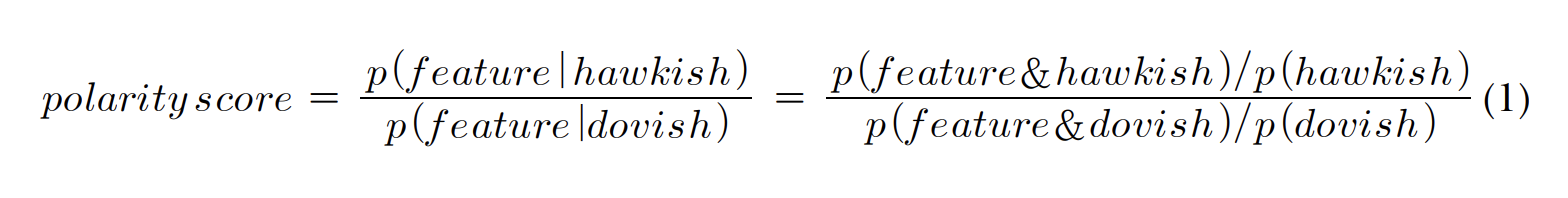

In [21]:
# method

from IPython.display import Image

corpus_df['polar_score'] = ((corpus_df['up'] / corpus_df['total']) / (corpus_df['up'].sum() / corpus_df['total'].sum())) / ((corpus_df['down'] / corpus_df['total']) / (corpus_df['down'].sum() / corpus_df['total'].sum()))
Image('/Users/cline_local/Datateam_cline/Analysis/How_to_calculate_polar_score.png')

In [22]:
corpus_df

,total,up,down,polar_score
조진/NNG,6,4,2,1.804388
석/NNG,11,7,4,1.578840
기술혁신/NNG,16,9,7,1.159964
트래블/NNG,30,19,11,1.558335
룰/NNG,32,21,11,1.722371
...,...,...,...,...
수고/NNG,1,0,1,0.000000
발전계획/NNG,1,0,1,0.000000
추천자/NNG,1,0,1,0.000000
답변자/NNG,1,0,1,0.000000


In [26]:
corpus_df['polarity'] = ""

In [27]:
for idx, value in tqdm(enumerate(corpus_df['polar_score'])):
    if corpus_df.iloc[idx].total > 14:
        if value > (13/10):
            corpus_df['polarity'][idx] = 'Hawkish'
        
        elif value < (10/13):
            corpus_df['polarity'][idx] = 'Dovish'
            
        else:
            corpus_df['polarity'][idx] = 'Nothing'
    
    else:
        corpus_df['polarity'][idx] = 'Nothing'

0it [00:00, ?it/s]<ipython-input-27-3641e0614116>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['polarity'][idx] = 'Nothing'
<ipython-input-27-3641e0614116>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['polarity'][idx] = 'Nothing'
<ipython-input-27-3641e0614116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['polarity'][idx] = 'Hawkish'
<ipython-input-27-3641e0614116>:7: SettingWithCopyWarning: 

In [23]:
corpus_df = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/corpus_df.csv')
corpus_df.columns = ['word', 'total', 'up', 'down']
corpus_df

,word,total,up,down
0,조진/NNG,6,4,2
1,석/NNG,11,7,4
2,기술혁신/NNG,16,9,7
3,트래블/NNG,30,19,11
4,룰/NNG,32,21,11
...,...,...,...,...
15090,수고/NNG,1,0,1
15091,발전계획/NNG,1,0,1
15092,추천자/NNG,1,0,1
15093,답변자/NNG,1,0,1


In [28]:
hawkish_dic = corpus_df[corpus_df['polarity'] == 'Hawkish']
dovish_dic = corpus_df[corpus_df['polarity'] == 'Dovish']

In [29]:
hawkish_dic

,total,up,down,polar_score,polarity
트래블/NNG,30,19,11,1.558335,Hawkish
룰/NNG,32,21,11,1.722371,Hawkish
시행령/NNG,112,76,34,2.016669,Hawkish
깊/VA,24,15,9,1.503657,Hawkish
대응/NNG,115,69,46,1.353291,Hawkish
...,...,...,...,...,...
원로/NNG,19,12,7,1.546618,Hawkish
수면/NNG,23,14,9,1.403413,Hawkish
보내온/VV,15,10,5,1.804388,Hawkish
올스타/NNG,17,11,6,1.654023,Hawkish


In [30]:
dovish_dic

,total,up,down,polar_score,polarity
법/NNG,542,247,293,0.760553,Dovish
해결책/NNG,20,9,11,0.738159,Dovish
세미나/NNG,51,23,28,0.741088,Dovish
우려/NNG,141,62,79,0.708051,Dovish
실명/NNG,76,31,45,0.621511,Dovish
...,...,...,...,...,...
오버/NNG,19,6,13,0.416397,Dovish
g7/NNG,18,3,15,0.180439,Dovish
와인/NNG,20,8,12,0.601463,Dovish
영주/NNG,23,7,16,0.394710,Dovish


In [29]:
hawkish_dic.columns = ['word', 'total', 'up', 'down', 'polar_score', 'polarity']
hawkish_dic

ValueError: Length mismatch: Expected axis has 5 elements, new values have 6 elements

In [108]:
dovish_dic.columns = ['word', 'total', 'up', 'down', 'polar_score', 'polarity']
dovish_dic

,word,total,up,down,polar_score,polarity
0,법/NNG,542,247,293,0.765636,Dovish
1,해결책/NNG,20,9,11,0.743092,Dovish
2,세미나/NNG,51,23,28,0.746041,Dovish
3,우려/NNG,141,62,79,0.712783,Dovish
4,실명/NNG,76,31,45,0.625665,Dovish
...,...,...,...,...,...,...
534,오버/NNG,19,6,13,0.419180,Dovish
535,g7/NNG,18,3,15,0.181645,Dovish
536,와인/NNG,20,8,12,0.605483,Dovish
537,영주/NNG,23,7,16,0.397348,Dovish


In [112]:
# dovish_dic.to_csv('dovish_dic.csv')

In [113]:
# hawkish_dic.to_csv('hawkish_dic.csv')

In [33]:
hawkish_dic.sort_values(by='up', ascending=False)

,total,up,down,polar_score,polarity
빗/NNG,504,312,192,1.466065,Hawkish
썸/NNG,440,272,168,1.460695,Hawkish
체인/NNG,337,204,133,1.383817,Hawkish
베이스/NNG,338,198,136,1.313488,Hawkish
주장/NNG,283,170,113,1.357283,Hawkish
...,...,...,...,...,...
압박/NNG,15,9,6,1.353291,Hawkish
이상거래/NNG,15,9,6,1.353291,Hawkish
강/NNG,15,9,6,1.353291,Hawkish
익숙/NNG,15,9,6,1.353291,Hawkish


In [44]:
# dovish_dic.sort_values(by='polar_score', ascending=False)
dovish_dic.sort_values(by='down', ascending=False)

,total,up,down,polar_score,polarity
법/NNG,542,247,293,0.760553,Dovish
설명/NNG,383,167,216,0.697530,Dovish
그룹/NNG,242,100,142,0.635348,Dovish
공식/NNG,257,117,140,0.753977,Dovish
승인/NNG,252,115,137,0.757316,Dovish
...,...,...,...,...,...
질서/NNG,16,7,9,0.701707,Dovish
졸업/NNG,15,6,9,0.601463,Dovish
소규모/NNG,16,7,9,0.701707,Dovish
발행주체/NNG,16,7,9,0.701707,Dovish


In [124]:
d = dovish_dic[['down']]
h = hawkish_dic[['up']]

### WordCloud 시각화

In [176]:
from wordcloud import WordCloud

wc = WordCloud(font_path='/Users/cline_local/Datateam_cline/Analysis/godoFont/GodoB.otf',
              background_color='white',
              width=1000,
              height=1000,
              max_words=600,
              max_font_size=200)

In [174]:
h_T = h.T
h_T = h_T.reset_index(drop=True)
h_T = h_T.to_dict('records')
h_T = h_T[0]
h_T

{'트래블/NNG': 19,
 '룰/NNG': 21,
 '시행령/NNG': 76,
 '깊/VA': 15,
 '대응/NNG': 69,
 '변동성/NNG': 54,
 '줄/VV': 125,
 '얻/VV': 61,
 '자본/NNG': 25,
 '빗/NNG': 312,
 '썸/NNG': 272,
 '토스/NNG': 21,
 '경쟁/NNG': 58,
 '단독/NNG': 12,
 '채/MAG': 69,
 '제조사/NNG': 22,
 '모델/NNG': 52,
 '성능/NNG': 14,
 '능력/NNG': 22,
 '금리/NNG': 29,
 '상승/NNG': 150,
 '서/VV': 16,
 '가량/NNG': 42,
 '회복/NNG': 23,
 '시설/NNG': 24,
 '아이/NNG': 25,
 '주장/NNG': 170,
 '변동/NNG': 37,
 '거의/MAG': 58,
 '사상/NNG': 49,
 '개당/NNG': 82,
 '수치/NNG': 39,
 '오갔/VV': 16,
 '차트/NNG': 16,
 '베이스/NNG': 198,
 '활성화/NNG': 41,
 '문/NNG': 49,
 '만난/VV': 16,
 '해지/NNG': 27,
 '가격/NNG;상승/NNG': 57,
 '역할/NNG': 96,
 '모았/VV': 44,
 '영업/NNG': 36,
 '열풍/NNG': 29,
 '추세/NNG': 36,
 '유입/NNG': 19,
 '물가/NNG': 12,
 '팀/NNG': 106,
 '심리/NNG': 11,
 '조정/NNG': 53,
 '안정/NNG': 34,
 '드러나/VV': 27,
 '대안/NNG': 22,
 '인/NNG': 41,
 '계속/NNG': 52,
 '이어지/VV': 61,
 '종료/NNG': 36,
 '정확/VAX': 25,
 '위안/NNG': 97,
 '수탁업무/NNG': 18,
 '인물/NNG': 39,
 '대학/NNG': 45,
 '감독청/NNG': 33,
 '안전성/NNG': 9,
 '지키/VV': 29,
 '기초/NNG': 11,
 '신규/N

In [177]:
wc.generate_from_frequencies(h_T)
wc.to_file('hawkish.png')

In [179]:
d_T = d.T
d_T = d_T.reset_index(drop=True)
d_T = d_T.to_dict('records')
d_T = d_T[0]
d_T

{'법/NNG': 293,
 '해결책/NNG': 11,
 '세미나/NNG': 28,
 '우려/NNG': 79,
 '실명/NNG': 45,
 '못/MAG': 38,
 '스퀘어/NNG': 54,
 '물/VV': 24,
 '힘들/VA': 12,
 '등장/NNG': 62,
 '현황/NNG': 44,
 '산/NNG': 12,
 '앞서/VV': 60,
 '같이/MAG': 76,
 '선물/NNG': 61,
 '금전/NNG': 11,
 '진흥/NNG': 38,
 '제한/NNG': 31,
 '금융사/NNG': 12,
 '인원/NNG': 73,
 '팍스/NNG': 25,
 '전통/NNG': 21,
 '손/NNG': 45,
 '닥/NNG': 13,
 '최신/NNG': 22,
 '캡/NNG': 30,
 '보건/NNG': 11,
 '담보/NNG': 44,
 '몰래/MAG': 14,
 '서류/NNG': 31,
 '장벽/NNG': 15,
 '달라지/VV': 12,
 '블로그/NNG': 74,
 '개방/NNG': 12,
 '걸음/NNG': 16,
 '매매/NNG': 31,
 '전담/NNG': 22,
 '바뀌/VV': 61,
 '일종/NNG': 29,
 '전례/NNG': 9,
 '규정/NNG': 116,
 '유행/NNG': 10,
 '이유/NNG': 95,
 '공포/NNG': 9,
 '식별/NNG': 19,
 '설명/NNG': 216,
 '셰어/NNG': 15,
 '증권거래소/NNG': 65,
 '수수료/NNG': 112,
 '인플레이션/NNG': 12,
 '시선/NNG': 13,
 '왔/VV': 11,
 '훨씬/MAG': 36,
 '모이/VV': 26,
 '시사/NNG': 10,
 '밋/NNG': 31,
 '이메일/NNG': 50,
 '공공/NNG': 40,
 '승인/NNG': 137,
 '꼽히/VV': 20,
 '활동/NNG': 80,
 '기구/NNG': 45,
 '그룹/NNG': 142,
 '살/VV': 40,
 '규제안/NNG': 13,
 '대량/NNG': 25,
 '진흥원/NNG'

In [180]:
wc.generate_from_frequencies(d_T)
wc.to_file('dovish.png')

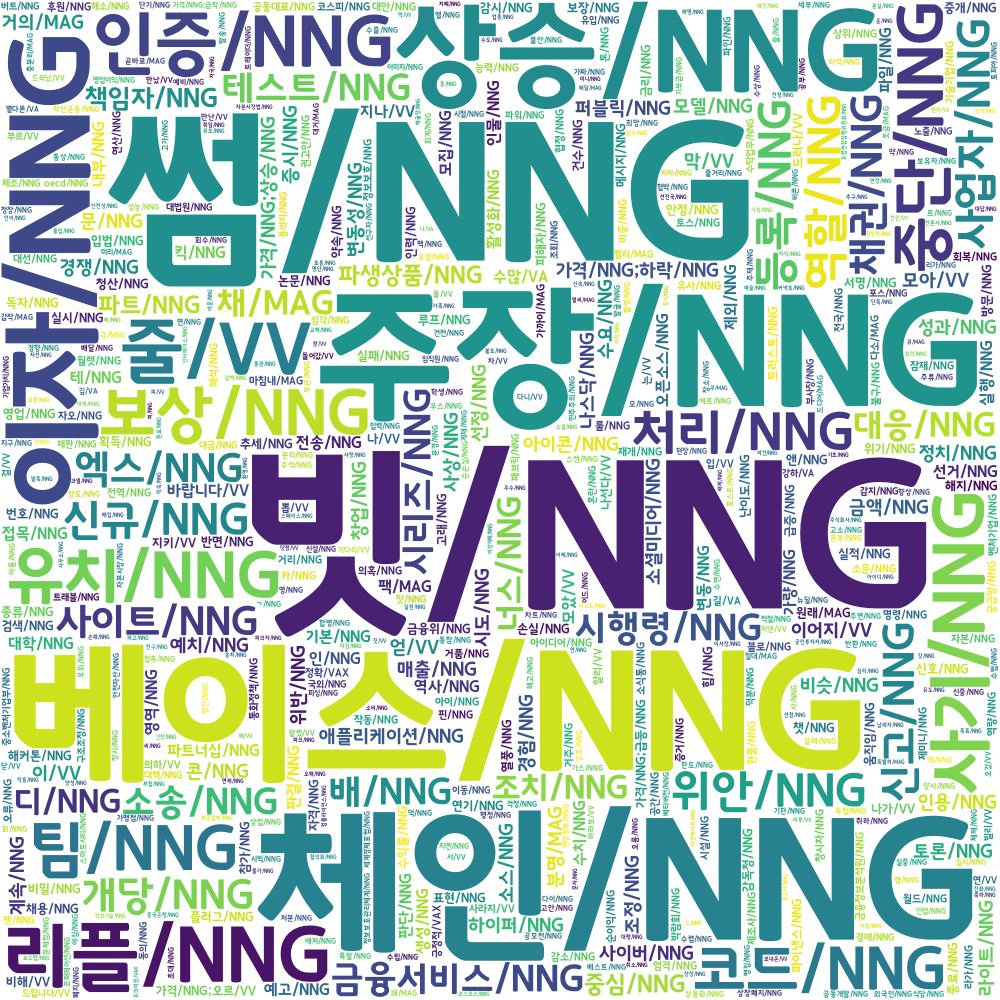

In [181]:
Image('/Users/cline_local/Datateam_cline/Analysis/hawkish.png')

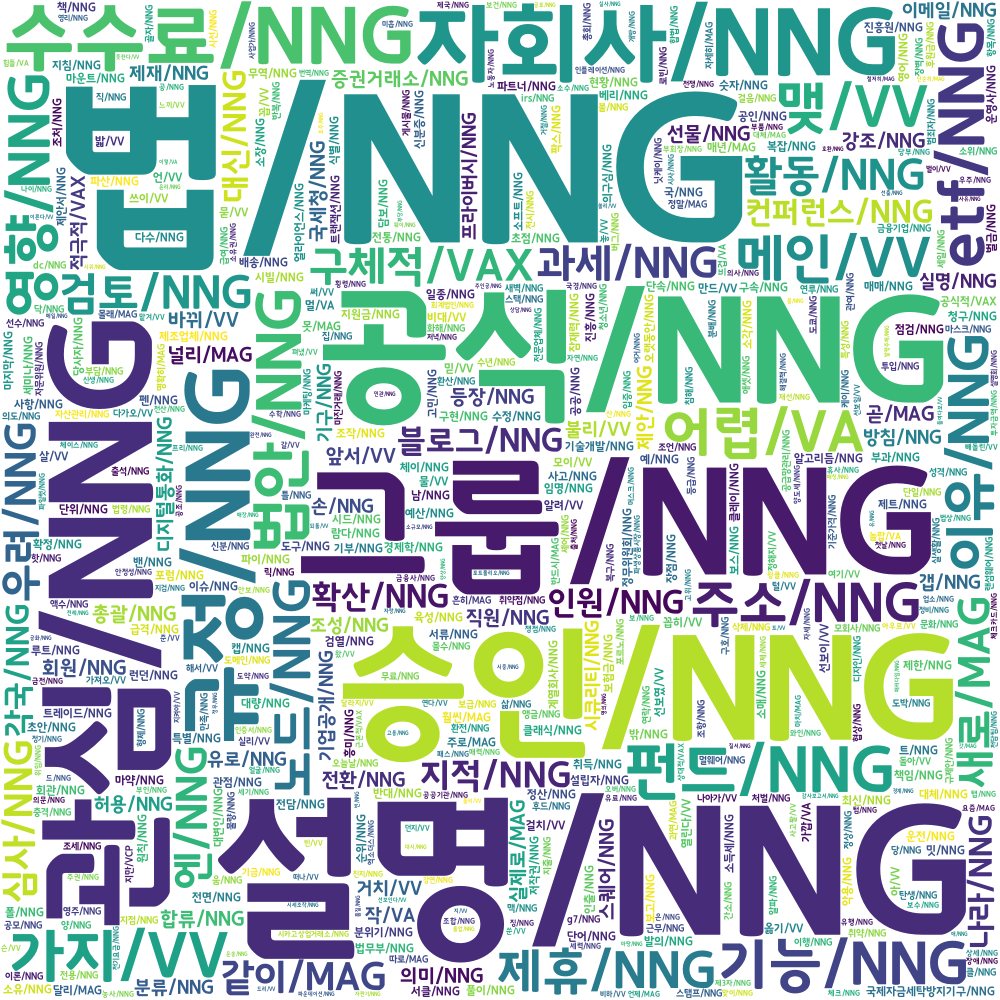

In [182]:
Image('/Users/cline_local/Datateam_cline/Analysis/dovish.png')

In [129]:
# Dovish = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/dovish_dic.csv')
# Hawkish = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/hawkish_dic.csv')

In [130]:
Hawkish.columns = ['hawkish', 'total', 'up', 'down', 'polar_score', 'polarity']
Dovish.columns = ['dovish', 'total', 'up', 'down', 'polar_score', 'polarity']
hawkish = Hawkish[['hawkish']]
dovish = Dovish[['dovish']]

In [131]:
hawkish_list = list(hawkish['hawkish'])
dovish_list = list(dovish['dovish'])

In [132]:
len(hawkish_list), len(dovish_list)

(584, 539)

---

### External Data(검증)

In [3]:
# main method
# 1.22 ~ 2.7일까지의 기사를 External Data(test datasets)로 사용

news_title = []
date_list = []
news_article = []

for i in tqdm(range(1, 7)):
    url = 'https://www.coindeskkorea.com/news/articleList.html?page={}&total=6048&box_idxno=&view_type=sm'.format(i)
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, 'html.parser')
    
    for j in range(1, 121):
        title = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-titles a strong'.format(j))
        date = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block div.list-dated'.format(j))
        article = soup.select('#user-container div.float-center.custom-m.mobile.template.list.max-width-1250 div.user-content section article div.article-list section div:nth-of-type({}) div.text-block p a'.format(j))
        
        news_title.append(title)
        date_list.append(date)
        news_article.append(article)
        
print("총 {}개의 전처리가 필요한 제목".format(len(news_title)))
print("총 {}개의 전처리가 필요한 날짜".format(len(date_list)))
print("총 {}개의 전처리가 필요한 기사".format(len(news_article)))

100%|██████████| 6/6 [00:14<00:00,  2.44s/it]

총 720개의 전처리가 필요한 제목
총 720개의 전처리가 필요한 날짜
총 720개의 전처리가 필요한 기사


In [17]:
test_title = []

for title in tqdm(news_title):
    for tit in title:
        for t in tit:
#             print(t)
            test_title.append(t)
            
print("전처리 후 제목: {}".format(len(test_title)))
test_title[:10]

100%|██████████| 720/720 [00:00<00:00, 1137010.12it/s]

전처리 후 제목: 120


['페이팔, 암호화폐 서비스 개시 후 매출 11.8% 증가',
 '[시황] CME 선물 출시 전, 이더 최고가 경신',
 '2/6 아침브리핑: 비트코인 취급하는 미국 수탁은행',
 '크로스앵글, 가상자산 성과측정 지수 2종 출시',
 '한정판 스니커즈 거래는 이더리움말고 헤데라에서',
 '2/5 오후브리핑: 정부 디파이 보고서, 레버리지, 도지코인',
 '[거래소 톺아보기] ②"하락장에도 수익" 국내 레버리지 상품',
 '이더 수수료 19달러 넘어…신난 채굴자들',
 '[시황] 비트코인 소폭 하락해 3만6300달러, 디파이 예치금 320억달러 돌파',
 '2/5 아침브리핑: 비트코인 투자 펀드의 부상']

In [23]:
test_source = []

for news in tqdm(news_article):
    for new in news:
        for nw in new:
            test_source.append(nw)
            
print(len(test_source))
print(test_source[:5])


test_clear_article = []

for i in tqdm(test_source):
    test_clear_article.append(i[6:-5])

print("전처리 후 제목: {}".format(len(test_clear_article)))
test_clear_article[:5]

100%|██████████| 120/120 [00:00<00:00, 624462.13it/s]

120
['\n\t\t\t\t\t미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 분기 실적을 공개했다. 페이팔은 2020년 4분기 전체 계좌가 1600만건 늘고, 총 결제액은 2770억달러에 육박했다고 발표했다.페이팔은 2020년 11월 미국 이용자 3억5000만명이 비트코인(BTC), 이더리움(ETH), 라이트코인(LTC), 비트코인캐시(BCH)를 매매할 수 있게 서비스 대상을 확대했다.페이팔은 최근 발행된 투자자 보고서에서 암호화폐를 구매한 이용자의 접속 횟수가 암호화폐 구매 이전보다 두배 정도 늘었다고 밝혔다.한편 페이팔의\t\t\t\t\t', '\n\t\t\t\t\t비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이더 선물 출시를 앞두고 이더는 또다시 역대 최고가를 경신했다. ■ 6일 오후 12시30분 기준 비트코인은 개당 약 3만9천달러대에 거래됐다. 24시간 사이 가격이 약 6% 상승했다.■ 24시간 동안 비트코인 가격은 3만7000 ~ 3만9600달러 사이를 오갔다.■ 비트코인 가격은 10시간 이동평균보다는 아래, 50시간 이동평균보다는 위에서 거래됐다. 기술적인 분석 기법에 따르면 이는 보합세의 신호다.나흘째 상승세가 이어지고 있는 비트코인 가격은 어젯밤\t\t\t\t\t', '\n\t\t\t\t\t주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프로테고 신탁은행(Protego Trust Bank)이 디지털자산의 수탁을 할 수 있는 내용의 신탁업 인가를 조건부 승인됐다.■ 프로테고는 앵커리지에 이어 통화감독청이 조건부 승인을 한 두번째 업체다. 지금까지 다수의 가상자산 업체들이 은행업 인가를 획득했는데, 와이오밍주에서 주 인가를 받은 암호화폐 거래소인 크라켄(Kraken)과 아반티(Avanti)도 여기에 포함된다.■ 한편, 암호화폐 지급결제 플랫폼인 메탈페이(Metal Pay)는 미국 전역에서\t\t\t\t\t', '\n\t\t\t\t\t가상자산(암

['미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 분기 실적을 공개했다. 페이팔은 2020년 4분기 전체 계좌가 1600만건 늘고, 총 결제액은 2770억달러에 육박했다고 발표했다.페이팔은 2020년 11월 미국 이용자 3억5000만명이 비트코인(BTC), 이더리움(ETH), 라이트코인(LTC), 비트코인캐시(BCH)를 매매할 수 있게 서비스 대상을 확대했다.페이팔은 최근 발행된 투자자 보고서에서 암호화폐를 구매한 이용자의 접속 횟수가 암호화폐 구매 이전보다 두배 정도 늘었다고 밝혔다.한편 페이팔의',
 '비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이더 선물 출시를 앞두고 이더는 또다시 역대 최고가를 경신했다. ■ 6일 오후 12시30분 기준 비트코인은 개당 약 3만9천달러대에 거래됐다. 24시간 사이 가격이 약 6% 상승했다.■ 24시간 동안 비트코인 가격은 3만7000 ~ 3만9600달러 사이를 오갔다.■ 비트코인 가격은 10시간 이동평균보다는 아래, 50시간 이동평균보다는 위에서 거래됐다. 기술적인 분석 기법에 따르면 이는 보합세의 신호다.나흘째 상승세가 이어지고 있는 비트코인 가격은 어젯밤',
 '주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프로테고 신탁은행(Protego Trust Bank)이 디지털자산의 수탁을 할 수 있는 내용의 신탁업 인가를 조건부 승인됐다.■ 프로테고는 앵커리지에 이어 통화감독청이 조건부 승인을 한 두번째 업체다. 지금까지 다수의 가상자산 업체들이 은행업 인가를 획득했는데, 와이오밍주에서 주 인가를 받은 암호화폐 거래소인 크라켄(Kraken)과 아반티(Avanti)도 여기에 포함된다.■ 한편, 암호화폐 지급결제 플랫폼인 메탈페이(Metal Pay)는 미국 전역에서',
 '가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는 지수 2종을 출시했다고 5일 밝혔다. 쟁글 라지 캡 인덱스(Xangl

In [24]:
normal_test_date = []

for date_ in tqdm(date_list):
    for date in date_:
        for d in date:
            normal_test_date.append(d)
            
normal_test_date = normal_test_date[1::2]
print("전처리 후 제목: {}".format(len(normal_test_date)))
normal_test_date[:10]

100%|██████████| 720/720 [00:00<00:00, 1021271.18it/s]

전처리 후 제목: 120


[' 2021-02-06 13:13',
 ' 2021-02-06 12:33',
 ' 2021-02-06 12:20',
 ' 2021-02-05 18:58',
 ' 2021-02-05 18:55',
 ' 2021-02-05 17:57',
 ' 2021-02-05 17:41',
 ' 2021-02-05 16:59',
 ' 2021-02-05 11:09',
 ' 2021-02-05 11:04']

In [25]:
clear_test_date = []

for _date in normal_test_date:
    clear_test_date.append(_date[1:-6])
    
clear_test_date[:5]

['2021-02-06', '2021-02-06', '2021-02-06', '2021-02-05', '2021-02-05']

In [29]:
test_day = pd.DataFrame(clear_test_date)
test_day.columns = ['datetimes']
test_article = pd.DataFrame(test_clear_article)
test_article.columns = ['article']

In [32]:
test_dataframe = pd.concat([test_day, test_article], axis = 1)
test_dataframe

,datetimes,article
0,2021-02-06,미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 ...
1,2021-02-06,비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이...
2,2021-02-06,주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프...
3,2021-02-05,가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는...
4,2021-02-05,명품의 유통을 추적하는 블록체인 스타트업 수쿠(SUKU)는 고가 스니커즈 검증 시스...
...,...,...
115,2021-01-22,글로벌 신용평가 기관 '스탠다드 앤드 푸어스'(S&P;)는 22일(현지시각) 공개한...
116,2021-01-22,비트코인은 가격도 거래량도 모두 내림세를 보였다.비트코인 가격은 이틀 연속 하락해 ...
117,2021-01-22,"미국 투자기관 구겐하임 파트너스의 스콧 마이너스 최고투자책임자(CIO)가 ""비트코인..."
118,2021-01-21,"KB국민은행 ""암호화폐 트래블룰, 화이트리스트로 해결 가능""조진석 KB국민은행 IT..."


In [6]:
test_date = pd.read_clipboard()
test_date.columns = ['datetimes', 'price']
test_date

,datetimes,price
0,2021-01-23,35287000.0
1,2021-01-24,35240000.0
2,2021-01-25,37816000.0
3,2021-01-26,35158500.0
4,2021-01-27,33515500.0
5,2021-01-28,35267500.0
6,2021-01-29,39404000.0
7,2021-01-30,37250000.0
8,2021-01-31,36609500.0
9,2021-02-01,36519500.0


In [7]:
# test_date.to_csv('test_data.csv')

In [11]:
test_a = test_date.loc[:][:][:-1]
test_b = test_date.loc[:][:][1:].rename({'date':'1일 전 date', 'price':'1일 전 price'}, axis='columns').reset_index(drop=True)

In [12]:
pd_test = pd.merge(test_a, test_b, left_index=True, right_index=True)

pd_test['price'] = pd_test['price'].astype(int)
pd_test['1일 전 price'] = pd_test['1일 전 price'].astype(int)
pd_test.columns = ['day-1', 'price-1', 'day', 'price']
pd_test

,day-1,price-1,day,price
0,2021-01-23,35287000,2021-01-24,35240000
1,2021-01-24,35240000,2021-01-25,37816000
2,2021-01-25,37816000,2021-01-26,35158500
3,2021-01-26,35158500,2021-01-27,33515500
4,2021-01-27,33515500,2021-01-28,35267500
5,2021-01-28,35267500,2021-01-29,39404000
6,2021-01-29,39404000,2021-01-30,37250000
7,2021-01-30,37250000,2021-01-31,36609500
8,2021-01-31,36609500,2021-02-01,36519500
9,2021-02-01,36519500,2021-02-02,37277500


In [13]:
pd_test['labeling'] = np.where(pd_test['price'] > pd_test['price-1'], 'up',
                                  np.where(pd_test['price'] == pd_test['price-1'], '-',
                                          'down'))

In [33]:
datelabel = ['day', 'price', 'labeling']
test_label = pd_test[datelabel]
test_label.columns = ['datetimes', 'price', 'labeling']
test_label

,datetimes,price,labeling
0,2021-01-24,35240000,down
1,2021-01-25,37816000,up
2,2021-01-26,35158500,down
3,2021-01-27,33515500,down
4,2021-01-28,35267500,up
5,2021-01-29,39404000,up
6,2021-01-30,37250000,down
7,2021-01-31,36609500,down
8,2021-02-01,36519500,down
9,2021-02-02,37277500,up


In [34]:
total_test = pd.merge(test_dataframe, test_label, on='datetimes')
total_test

,datetimes,article,price,labeling
0,2021-02-06,미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 ...,42936500,up
1,2021-02-06,비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이...,42936500,up
2,2021-02-06,주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프...,42936500,up
3,2021-02-05,가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는...,40330000,up
4,2021-02-05,명품의 유통을 추적하는 블록체인 스타트업 수쿠(SUKU)는 고가 스니커즈 검증 시스...,40330000,up
...,...,...,...,...
99,2021-01-25,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글...",37816000,up
100,2021-01-25,2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...,37816000,up
101,2021-01-25,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...,37816000,up
102,2021-01-24,조 바이든 미국 대통령이 취임한 지 이틀이 지난 시점에 칼럼을 쓴다.신임 대통령은 ...,35240000,down


In [35]:
# total_test.to_csv('total_test_dataframe.csv')

In [184]:
total_test = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/total_test_dataframe.csv')
total_test[['datetimes', 'article', 'price']]
total_test

,Unnamed: 0,datetimes,article,price,labeling
0,0,2021-02-06,미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 ...,42936500,up
1,1,2021-02-06,비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이...,42936500,up
2,2,2021-02-06,주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프...,42936500,up
3,3,2021-02-05,가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는...,40330000,up
4,4,2021-02-05,명품의 유통을 추적하는 블록체인 스타트업 수쿠(SUKU)는 고가 스니커즈 검증 시스...,40330000,up
...,...,...,...,...,...
99,99,2021-01-25,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글...",37816000,up
100,100,2021-01-25,2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...,37816000,up
101,101,2021-01-25,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...,37816000,up
102,102,2021-01-24,조 바이든 미국 대통령이 취임한 지 이틀이 지난 시점에 칼럼을 쓴다.신임 대통령은 ...,35240000,down


In [185]:
n_tokenize(total_test)
total_test

0it [00:00, ?it/s]<ipython-input-8-580d3387c2b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['token'][idx] = only_token
104it [00:00, 201.77it/s]


,Unnamed: 0,datetimes,article,price,labeling,token
0,0,2021-02-06,미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 ...,42936500,up,"[[결제/NNG, 업체/NNG, 페이팔/NNG, 암호화폐/NNG, 팔/VV, 있/V..."
1,1,2021-02-06,비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이...,42936500,up,"[[비트코인/NNG, 상승/NNG, 달러/NNG, 돌파/NNG, 하/VV], [오/..."
2,2,2021-02-06,주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프...,42936500,up,"[[소식/NNG], [암호화폐/NNG, 은행/NNG, 통화/NNG, 감독청/NNG,..."
3,3,2021-02-05,가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는...,40330000,up,"[[가상/NNG, 자산/NNG, 암호화폐/NNG, 공시/NNG, 운영/NNG, 하/..."
4,4,2021-02-05,명품의 유통을 추적하는 블록체인 스타트업 수쿠(SUKU)는 고가 스니커즈 검증 시스...,40330000,up,"[[명품/NNG, 유통/NNG, 추적/NNG, 하/XSV, 블록체인/NNG, 스타트..."
...,...,...,...,...,...,...
99,99,2021-01-25,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글...",37816000,up,"[[상하이/NNG, 위안/NNG, 프로젝트/NNG, 참여/NNG, 하/VV], [글..."
100,100,2021-01-25,2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...,37816000,up,"[[비트코인/NNG, 가격/NNG, 상승/NNG, 하/XSV, 암호화폐/NNG, 거..."
101,101,2021-01-25,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...,37816000,up,"[[가짜/NNG, 또/MAG, 화제/NNG], [자신/NNG, 비트코인/NNG, 창..."
102,102,2021-01-24,조 바이든 미국 대통령이 취임한 지 이틀이 지난 시점에 칼럼을 쓴다.신임 대통령은 ...,35240000,down,"[[취임/NNG, 하/VV, 칼럼/NNG, 쓴다/VV], [이미/MAG, 행정명령/..."


In [186]:
total_test['article'] = total_test['article'].astype(str)

In [187]:
doc_score_list = []


for i in range(len(total_test)):
    news_score_list = []
    
    for sentence in total_test['token'][i]:
        dict_sentence = [[], []]
        
        for token in sentence:
            if token in dovish_list:
                dict_sentence[1].append(token)
            elif token in hawkish_list:
                dict_sentence[0].append(token)
            
            tone_score = []
            if (len(dict_sentence[0]) + len(dict_sentence[1])) == 0:
                tone_score.append('')
            else:
                tone_score.append((len(dict_sentence[0]) - len(dict_sentence[1])) / (len(dict_sentence[0]) + len(dict_sentence[1])))
            
            news_score_list.append(tone_score)
            
        doc_score_list.append(news_score_list)
        
doc_score_list[:5]

[[[''],
  [''],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  ['']],
 [[''],
  [''],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [0.3333333333333333],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  

In [188]:
each_doc_tone = []

for i in range(len(doc_score_list)):
    doc_tone = []
    
    if doc_score_list[i] == []:
        doc_tone.append('')
    
    else:
        no_of_hawkish = 0
        no_of_dovish = 0
        
        for j in range(len(doc_score_list[i])):
            if doc_score_list[i][j][0] != '':
                if doc_score_list[i][j][0] > 0:
                    no_of_hawkish += 1
                elif doc_score_list[i][j][0] < 0:
                    no_of_dovish += 1
            else:
                continue
        
        tone = (no_of_hawkish - no_of_dovish) / (no_of_hawkish + no_of_dovish)
        doc_tone.append(tone)
        
    each_doc_tone.append(doc_tone)

In [189]:
total_test

,Unnamed: 0,datetimes,article,price,labeling,token
0,0,2021-02-06,미국의 결제업체 페이팔이 암호화폐를 사고 팔 수 있는 서비스를 개시한 후 처음으로 ...,42936500,up,"[[결제/NNG, 업체/NNG, 페이팔/NNG, 암호화폐/NNG, 팔/VV, 있/V..."
1,1,2021-02-06,비트코인은 상승해 3만9천달러를 돌파했다. 오는 8일 시카고상업거래소(CME)의 이...,42936500,up,"[[비트코인/NNG, 상승/NNG, 달러/NNG, 돌파/NNG, 하/VV], [오/..."
2,2,2021-02-06,주요 소식1. 암호화폐 + 은행■ 미국 통화감독청(OCC)은 시애틀에 본사를 둔 프...,42936500,up,"[[소식/NNG], [암호화폐/NNG, 은행/NNG, 통화/NNG, 감독청/NNG,..."
3,3,2021-02-05,가상자산(암호화폐) 공시 포털 쟁글을 운영하는 크로스앵글이 가상자산 성과를 추종하는...,40330000,up,"[[가상/NNG, 자산/NNG, 암호화폐/NNG, 공시/NNG, 운영/NNG, 하/..."
4,4,2021-02-05,명품의 유통을 추적하는 블록체인 스타트업 수쿠(SUKU)는 고가 스니커즈 검증 시스...,40330000,up,"[[명품/NNG, 유통/NNG, 추적/NNG, 하/XSV, 블록체인/NNG, 스타트..."
...,...,...,...,...,...,...
99,99,2021-01-25,"베이징, 상하이시 등 중국 대도시들이 디지털 위안(DCEP) 프로젝트에 참여한다.글...",37816000,up,"[[상하이/NNG, 위안/NNG, 프로젝트/NNG, 참여/NNG, 하/VV], [글..."
100,100,2021-01-25,2020년 연말 비트코인 가격이 반등하면서 암호화폐 거래소 코인베이스도 한 차례 큰...,37816000,up,"[[비트코인/NNG, 가격/NNG, 상승/NNG, 하/XSV, 암호화폐/NNG, 거..."
101,101,2021-01-25,'가짜 사토시(Faketoshi)'가 또 한 번 화제다.자신이 비트코인 창시자 사토...,37816000,up,"[[가짜/NNG, 또/MAG, 화제/NNG], [자신/NNG, 비트코인/NNG, 창..."
102,102,2021-01-24,조 바이든 미국 대통령이 취임한 지 이틀이 지난 시점에 칼럼을 쓴다.신임 대통령은 ...,35240000,down,"[[취임/NNG, 하/VV, 칼럼/NNG, 쓴다/VV], [이미/MAG, 행정명령/..."


In [190]:
total_test['tone'] = total_test['datetimes']

for i in tqdm(range(len(each_doc_tone))):
    total_test['tone'][i] = each_doc_tone[i][0]

  0%|          | 0/553 [00:00<?, ?it/s]<ipython-input-190-cff6cc14d08f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_test['tone'][i] = each_doc_tone[i][0]
100%|██████████| 553/553 [00:00<00:00, 2797.22it/s]


In [191]:
total_df = total_test[['datetimes', 'price', 'tone', 'labeling']]
total_df

,datetimes,price,tone,labeling
0,2021-02-06,42936500,1,up
1,2021-02-06,42936500,1,up
2,2021-02-06,42936500,1,up
3,2021-02-05,40330000,1,up
4,2021-02-05,40330000,1,up
...,...,...,...,...
99,2021-01-25,37816000,1,up
100,2021-01-25,37816000,1,up
101,2021-01-25,37816000,1,up
102,2021-01-24,35240000,1,down


In [192]:
int_tone = total_df['tone'].tolist()
int_price = total_df['price'].tolist()

print(int_tone[:5])
print(int_price[:5])

[1.0, 1.0, 1.0, 1.0, 1.0]
[42936500, 42936500, 42936500, 40330000, 40330000]


In [36]:
# total_df.to_csv('result.csv')

In [193]:
total_df['tone'] = total_df['tone'].astype('float64')
total_df['price'] = total_df['price'].astype('float64')

<ipython-input-193-3d5f875dec07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['tone'] = total_df['tone'].astype('float64')
<ipython-input-193-3d5f875dec07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['price'] = total_df['price'].astype('float64')


In [194]:
grip = total_df[['price', 'tone', 'labeling']].groupby(total_df['datetimes'])
grip = grip.mean()
grip

,price,tone
datetimes,,
2021-01-24,35240000.0,0.440000
2021-01-25,37816000.0,1.000000
2021-01-26,35158500.0,0.257636
2021-01-27,33515500.0,0.221192
2021-01-28,35267500.0,-0.126667
2021-01-29,39404000.0,0.302609
2021-01-30,37250000.0,1.000000
2021-01-31,36609500.0,1.000000
2021-02-01,36519500.0,0.428571


In [205]:
# grip.to_csv('grip.csv')

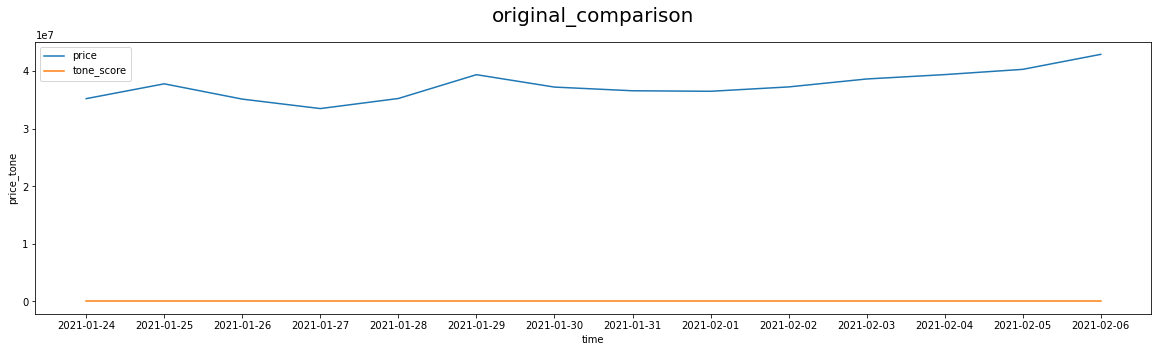

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.title('original_comparison', fontsize=20, pad=20)
plt.xlabel('time')
plt.ylabel('price_tone')
plt.plot(grip)
plt.legend(['price', 'tone_score'])
plt.show()

In [198]:
grip['price'].corr(grip['tone'])

0.2996615935443728

In [207]:
f = pd.read_csv('/Users/cline_local/Datateam_cline/Analysis/grip.csv')
f

,datetimes,price,tone
0,2021-01-24,35240000.0,0.440000
1,2021-01-25,37816000.0,1.000000
2,2021-01-26,35158500.0,0.257636
3,2021-01-27,33515500.0,0.221192
4,2021-01-28,35267500.0,-0.126667
5,2021-01-29,39404000.0,0.302609
6,2021-01-30,37250000.0,1.000000
7,2021-01-31,36609500.0,1.000000
8,2021-02-01,36519500.0,0.428571
9,2021-02-02,37277500.0,-0.282609


In [208]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

minmax = MinMaxScaler()
std = StandardScaler()

x_minmax = minmax.fit_transform(grip)
x_std = std.fit_transform(grip)

In [212]:
x_std_df = pd.DataFrame(x_std)
x_std_df.columns = ['std_price', 'std_tone']
x_std_df2 = x_std_df.set_index(f['datetimes'])
x_std_df2

,std_price,std_tone
datetimes,,
2021-01-24,-0.959687,0.013176
2021-01-25,0.120564,1.387092
2021-01-26,-0.993865,-0.434239
2021-01-27,-1.682860,-0.523654
2021-01-28,-0.948155,-1.377096
2021-01-29,0.786495,-0.323903
2021-01-30,-0.116790,1.387092
2021-01-31,-0.385385,1.387092
2021-02-01,-0.423126,-0.014863


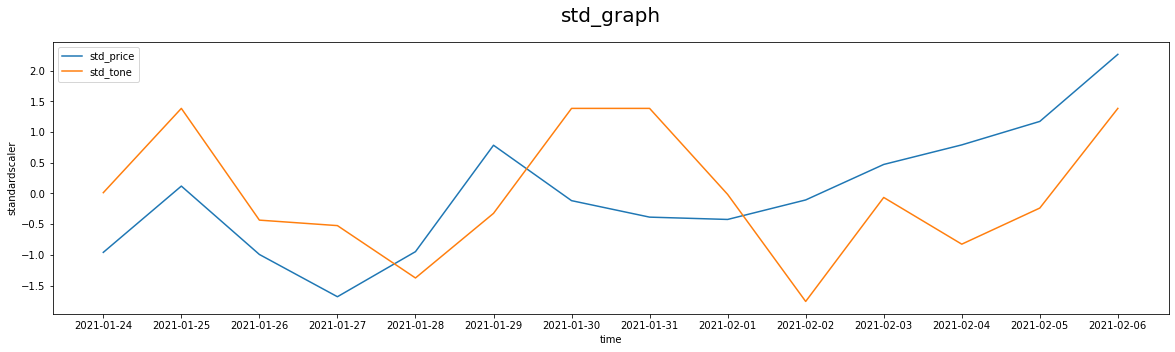

In [215]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.title('std_graph', fontsize=20, pad=20)
plt.xlabel('time')
plt.ylabel('standardscaler')
plt.plot(x_std_df2)
plt.legend(['std_price', 'std_tone'])
plt.show()

In [82]:
x_std_df['std_price'].corr(x_std_df['std_tone']) * 100

29.966159354437274

In [78]:
x_minmax_df = pd.DataFrame(x_minmax)
x_minmax_df.columns = ['minmax_price', 'minmax_tone']
x_minmax_df

,minmax_price,minmax_tone
0,0.183049,0.563390
1,0.456480,1.000000
2,0.174398,0.421208
3,0.000000,0.392793
4,0.185968,0.121582
5,0.625040,0.456271
6,0.396402,1.000000
7,0.328415,1.000000
8,0.318862,0.554479
9,0.399321,0.000000


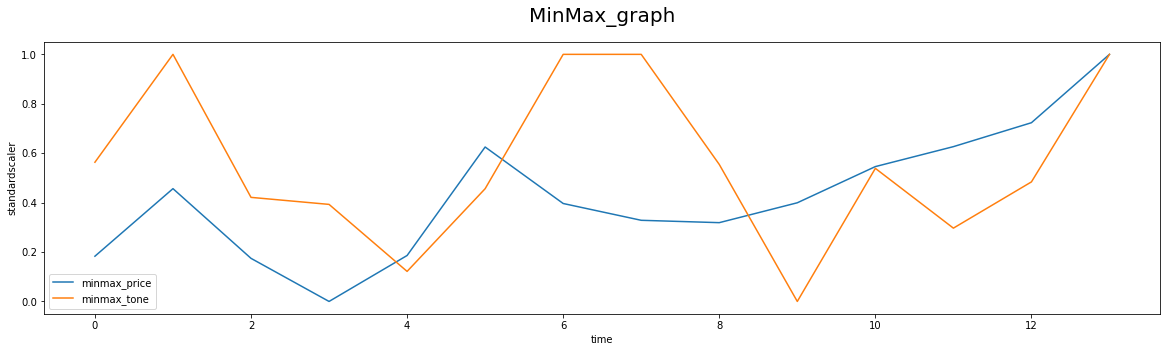

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.title('MinMax_graph', fontsize=20, pad=20)
plt.xlabel('time')
plt.ylabel('standardscaler')
plt.plot(x_minmax_df)
plt.legend(['minmax_price', 'minmax_tone'])
plt.show()

In [121]:
x_minmax_df['minmax_price'].corr(x_minmax_df['minmax_tone']) * 100

29.966159354437284

### 추가검증 요청

테슬라, 1.6조원 비트코인 매수…‘전기차 결제도 비트코인으로’  
https://www.coindeskkorea.com/news/articleView.html?idxno=72735  
캐나다 금융당국, 비트코인 ETF 첫 승인  
http://www.coindeskkorea.com/news/articleView.html?idxno=72761  
모건스탠리, 비트코인 투자 검토 중  
http://www.coindeskkorea.com/news/articleView.html?idxno=72762  
미국 SEC-리플, 합의 가능성 희박...공동서한 법원 제출  
http://www.coindeskkorea.com/news/articleView.html?idxno=72778

In [8]:
date_list = ['2021-02-09']
news = ['''1. 테슬라가 15억달러 어치의 비트코인 매수. 글로벌 전기차 기업인 테슬라가 15억달러 어치의  비트코인을 매수했다고 밝혔다. 미국 증권거래위원회(SEC) 연간보고서에 따르면 테슬라는 지난 1월 기업자금을 “더 유연하고 효율적으로 운영하기 위해 투자 정책을 업데이트했으며, 이 정책에 따라 총 15억달러 어치의 비트코인을 취득했다”고 밝혔다. 작년 말 기준 테슬라 현금과 현금등가물은 총 190억달러 정도다.
테슬라의 비트코인 매수 소식이 전해지자 개당 3만9000달러 선을 횡보하던 비트코인 가격은 40여분만에 글로벌 기준 4만5000달러 가깝게 급등했다. 가격 급등으로 암호화폐 거래소 사용량이 늘어나면서, 바이낸스 등 일부 글로벌 거래소는 몇십분 간 사용이 불가능한 상태가 되기도 했다. 테슬라는 비트코인을 “가까운 미래에 결제수단으로 용인할 예정”이라고도 밝혔다.
테슬라 CEO인 일론 머스크는 최근 음성 소셜미디어 애플리케이션 클럽하우스(Clubhouse)에서 "8년 전에 비트코인을 샀어야 했다"며 "비트코인을 현재 긍정적으로 보고 있으며 지지한다"고 말한 바 있다. 머스크를 포함한 많은 기업인이 코로나19로 인한 경제적 혼란 속에서 비트코인 등 암호화폐에 관심을 보이고 있다.
'헤지펀드 전설'로 불리는 빌 밀러도 며칠 전 BTC(비트코인) 노출 비중을 15%까지 높이기 위해 그레이스케일 비트코인 신탁(GBTC)를 매입하겠다고 밝혔다.
6일(현지시간) SEC에 제출한 규제 신고서에 따르면, 밀러 밸류 펀드는 "그레이스케일 비트코인 신탁 상품에 투자해 간접적으로 비트코인에 대한 노출 방안을 모색할 수 있다"며 "그 결과 비트코인에의 노출 비중이 15%를 넘기면 추가 매입은 없다"고 밝혔다.(그레이스케일은 코인데스크의 자매회사다.)
빌 밀러는 자사 최상위 펀드인 '밀러 오퍼튜니티 신탁'을 통해 이번 투자를 진행한다는 방침인데 밀러는 지난해 12월31일 기준 22억5000만달러의 자금을 운용하고 있으며, 이 중 최대 3억3700만달러(3800억원)를 GBTC에 투자할 계획이다.''']

In [9]:
news_article = []

for i in tqdm(news):
    news_article.append(i)
    
news_article

100%|██████████| 1/1 [00:00<00:00, 3819.95it/s]


['1. 테슬라가 15억달러 어치의 비트코인 매수. 글로벌 전기차 기업인 테슬라가 15억달러 어치의  비트코인을 매수했다고 밝혔다. 미국 증권거래위원회(SEC) 연간보고서에 따르면 테슬라는 지난 1월 기업자금을 “더 유연하고 효율적으로 운영하기 위해 투자 정책을 업데이트했으며, 이 정책에 따라 총 15억달러 어치의 비트코인을 취득했다”고 밝혔다. 작년 말 기준 테슬라 현금과 현금등가물은 총 190억달러 정도다.\n테슬라의 비트코인 매수 소식이 전해지자 개당 3만9000달러 선을 횡보하던 비트코인 가격은 40여분만에 글로벌 기준 4만5000달러 가깝게 급등했다. 가격 급등으로 암호화폐 거래소 사용량이 늘어나면서, 바이낸스 등 일부 글로벌 거래소는 몇십분 간 사용이 불가능한 상태가 되기도 했다. 테슬라는 비트코인을 “가까운 미래에 결제수단으로 용인할 예정”이라고도 밝혔다.\n테슬라 CEO인 일론 머스크는 최근 음성 소셜미디어 애플리케이션 클럽하우스(Clubhouse)에서 "8년 전에 비트코인을 샀어야 했다"며 "비트코인을 현재 긍정적으로 보고 있으며 지지한다"고 말한 바 있다. 머스크를 포함한 많은 기업인이 코로나19로 인한 경제적 혼란 속에서 비트코인 등 암호화폐에 관심을 보이고 있다.\n\'헤지펀드 전설\'로 불리는 빌 밀러도 며칠 전 BTC(비트코인) 노출 비중을 15%까지 높이기 위해 그레이스케일 비트코인 신탁(GBTC)를 매입하겠다고 밝혔다.\n6일(현지시간) SEC에 제출한 규제 신고서에 따르면, 밀러 밸류 펀드는 "그레이스케일 비트코인 신탁 상품에 투자해 간접적으로 비트코인에 대한 노출 방안을 모색할 수 있다"며 "그 결과 비트코인에의 노출 비중이 15%를 넘기면 추가 매입은 없다"고 밝혔다.(그레이스케일은 코인데스크의 자매회사다.)\n빌 밀러는 자사 최상위 펀드인 \'밀러 오퍼튜니티 신탁\'을 통해 이번 투자를 진행한다는 방침인데 밀러는 지난해 12월31일 기준 22억5000만달러의 자금을 운용하고 있으며, 이 중 최대 3억3700만달러(3800억원

In [14]:
test1 = pd.DataFrame(news_article)
test1.columns = ['article']

n_tokenize(test1)

1it [00:00,  4.79it/s]


In [19]:
test1

,article,token
0,1. 테슬라가 15억달러 어치의 비트코인 매수. 글로벌 전기차 기업인 테슬라가 15...,"[[달러/NNG, 비트코인/NNG, 매수/NNG], [글로벌/NNG, 전기차/NNG..."


In [45]:
doc_score_list = []


for i in range(len(test2)):
    news_score_list = []
    
    for sentence in test2['token'][i]:
        dict_sentence = [[], []]
        
        for token in sentence:
            if token in dovish_list:
                dict_sentence[1].append(token)
            elif token in hawkish_list:
                dict_sentence[0].append(token)
            
            tone_score = []
            if (len(dict_sentence[0]) + len(dict_sentence[1])) == 0:
                tone_score.append('')
            else:
                tone_score.append((len(dict_sentence[0]) - len(dict_sentence[1])) / (len(dict_sentence[0]) + len(dict_sentence[1])))
            
            news_score_list.append(tone_score)
            
        doc_score_list.append(news_score_list)
        
doc_score_list[:5]

[[[''],
  [''],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [''],
  [''],
  [''],
  [''],
  [''],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [''],
  [''],
  [''],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [0.0],
  [0.0],
  [-0.3333333333333333],
  [-0.3333333333333333],
  [-0.3333333333333333],
  [-0.3333333333333333],
  [-0.3333333333333333],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [-0.3333333333333333],
  [0.0],
  [-0.2],
  [-0.2],
  [-0.2],
  [0.0],
  [-0.14285714285714285],
  [-0.14285714285714285],
  [0.0],
  [0.0],
  [0.1111111111111111],
  [0.1111111111111111],
  [0.1111111111111111],
  [1.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.3333333333333333],
  [0.5],
  [0.5],
  [0.5],
  [0.2],
  [0.2],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [-0.3

In [46]:
each_doc_tone = []

for i in range(len(doc_score_list)):
    doc_tone = []
    
    if doc_score_list[i] == []:
        doc_tone.append('')
    
    else:
        no_of_hawkish = 0
        no_of_dovish = 0
        
        for j in range(len(doc_score_list[i])):
            if doc_score_list[i][j][0] != '':
                if doc_score_list[i][j][0] > 0:
                    no_of_hawkish += 1
                elif doc_score_list[i][j][0] < 0:
                    no_of_dovish += 1
            else:
                continue
        
        tone = (no_of_hawkish - no_of_dovish) / (no_of_hawkish + no_of_dovish)
        doc_tone.append(tone)
        
    each_doc_tone.append(doc_tone)

In [47]:
test2

,article,token
0,캐나다 금융 당국이 북미 최초로 비트코인 상장지수펀드(ETF) 출시를 승인했다.\n...,"[[최초/NNG, 비트코인/NNG, etf/NNG, etf/NNG, 출시/NNG, ..."
1,투자은행 모건스탠리에서 1500억달러 규모의 자금을 운용하는 투자전문 자회사 카운터...,"[[투자은행/NNG, 달러/NNG, 규모/NNG, 자금/NNG, 운용/NNG, 하/..."
2,미국 증권거래위원회(SEC)와 리플 간 합의 가능성이 희박한 것으로 나타났다.\nS...,"[[증권거래위원회/NNG, 리플/NNG, 합의/NNG, 가능성/NNG, 희박/NNG..."


In [26]:
test1['tone'] = test1['article']

for i in tqdm(range(len(each_doc_tone))):
    test1['tone'][i] = each_doc_tone[i][0]

100%|██████████| 13/13 [00:00<00:00, 2039.88it/s]


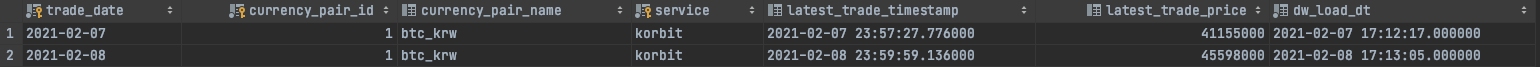

In [32]:
from IPython.display import Image

Image('/Users/cline_local/Datateam_cline/Analysis/test1.png')

In [30]:
int_tone = test1['tone'].tolist()

print(int_tone[:5])

[-0.17073170731707318]


In [37]:
news2 = ['''캐나다 금융 당국이 북미 최초로 비트코인 상장지수펀드(ETF) 출시를 승인했다.
온타리오증권위원회(OSC)는 캐나다 기반 자산운용사 퍼포즈 인베스트먼트가 신청한 비트코인 ETF 출시를 11일 승인했다. 
캐나다 투자 관리 회사 3iQ가 상장한 펀드를 비롯한 복수의 폐쇄형 (close-ended) 비트코인 펀드가 토론토 증권거래소에 이미 상장돼 있지만, 이는 ETF와는 차이가 있다. ETF의 경우 증권을 지속해서 발행하는 반면, 폐쇄형 펀드는 최초 판매 시와 판매 재개 시에만 증권을 발행한다. 
퍼포즈 인베스트먼트가 온라인에 게시한 설명 자료에 따르면, 이번에 승인을 얻은 펀드는 비트코인 가격 변동성에서 수수료와 비용을 제외한 만큼의 실적을 추종한다. 퍼포즈 인베스트먼트는 이 ETF가 비트코인 가격의 단기적 변동성에 투기하진 않을 것이라고 설명했다. 
퍼포즈 인베스트먼트는 비트코인 ETF가 장기적 관점의 자산 성장과 매력적인 위험 조정 수익률을 추구하며 '고위험'을 용인할 수 있는 투자자를 주된 대상으로 한다고 밝혔다. 
일반적으로 ETF는 바스켓 내 복수의 상품에 투자한다는 점에서 뮤추얼 펀드와 유사하다. 다만, 거래소를 통해 거래된다는 점에선 증권에 더 가깝다. ETF 상품의 위험도는 어떤 자산을 기초 자산으로 하느냐에 따라 달라진다. 비트코인 ETF는 대개 "고위험" 상품으로 여겨진다.
투자를 통해 "지속적인 수입원"을 만들고자 하는 이들에겐 일반적으로 비트코인 ETF 투자를 권하지 않는다. 
퍼포즈 인베스트먼트 비트코인 ETF의 수수료는 관리 수수료와 운영 및 거래 비용 등으로 구성된다. 현재 연 수수료는 비트코인 가치의 1%로 설정돼 있다. 펀드가 이제 막 출시된 만큼, 운영비와 거래 수수료는 아직 제공되지 않았다.
에릭 발추나스 블룸버그 시니어 애널리스트는 이번 소식이 미국이 제재를 가한 비트코인 ETF에 '좋은 신호'가 될 거라고 믿는다고 말했다.
그는 트위터를 통해 "캐나다의 진보적인 규제 당국을 사랑한다. 아마도 그들이 정상이고, 미국 증권거래위원회(SEC)가 너무 보수적인 것인지도 모른다"고 말했다. 그는 "어찌 됐건 미국도 곧 그 뒤를 따르게 될 것"이라고 덧붙였다.
토론토 증권거래소는 해당 펀드를 캐나다 달러로 상장할 것으로 보인다. 포트폴리오 및 펀드 관리는 퍼포즈 인베스트먼트가 담당한다.''',
        '''투자은행 모건스탠리에서 1500억달러 규모의 자금을 운용하는 투자전문 자회사 카운터포인트 글로벌(Counterpoint Global)을 통해 비트코인에 베팅하는 방안을 검토하고 있다고 블룸버그가 복수의 소식통을 인용해 보도했다.
즉각적인 투자가 가능한 상황은 아니다. 블룸버그는 카운터포인트 글로벌이 계획하고 있는 비트코인 투자를 추진하기 위해서는 모건스탠리와 규제당국의 허가를 먼저 받아야 한다고 설명했다.
모건스탠리가 업계 대표 암호화폐인 비트코인에 투자하는 것은 이번이 처음이 아니다. 코인데스크 보도에 따르면, 모건스탠리는 고비중 비트코인 투자로 최근 유명해진 나스닥 상장기업 마이크로스트래티지(MicroStrategy) 지분을 11% 가까이 보유하고 있다.
모건스탠리 애널리스트들은 비트코인이 미국 달러를 위협할 수 있는 잠재력을 갖고 있다고 지적하면서도, 최근 공개된 보고서에서는 비트코인을 장기보유하는 투자자가 많아질수록 결제 수단으로의 가치는 떨어질 수 있다고 강조했다.
카운터포인트 글로벌은 현재 20개 가까운 펀드를 운용하고 있으며, 블룸버그는 이 중 5개 펀드가 지난해 100% 이상의 수익률을 달성했다고 전했다. 모건스탠리는 블룸버그 보도 내용에 대한 언급을 삼가고 있다.''',
        '''미국 증권거래위원회(SEC)와 리플 간 합의 가능성이 희박한 것으로 나타났다.
SEC와 리플은 16일(현지시간) 아날리사 토레스(Analisa Torres) 뉴욕 남부지방법원 연방판사에게 제출한 서한을 통해 "현재로서는 (재판 전) 해결 가능성이 없다"고 밝혔다.
이어 "트럼프 행정부 시절 합의안에 대한 논의가 이어졌으나 당시 주축을 이뤘던 부서장들이 SEC를 떠났다"며 "새로운 합의가 이뤄질 경우 즉시 법원에 통보하겠다"고 덧붙였다.    
SEC와 리플은 증거개시(Discovery: 소송 당사자들이 재판에 앞서 증거와 정보를 서로 공개하게 하는 제도)를 8월 16일까지 종료하기로 동의했다. 
SEC는 이번 서한에서 "리플과 크리스 라센 의장은 XRP가 ‘투자 계약’으로 간주될 위험이 있으며 증권법상 증권으로 간주될 수 있다고 경고하는 법률 메모를 받은 바 있다"며 리플에게 추가 증언 녹취록을 제출할 것을 요구했다. 하지만 리플은 "SEC의 요청은 부적절하고 법적 근거도 부족하다"며 이를 거절했다. 
앞서 지난해 12월 SEC는 XRP가 미등록 증권이라는 이유로 리플을 증권법 위반 혐의로 고소했다. SEC와 리플 간 최초 변론 전 회의(pretrial conference)는 2월 22일로 예정됐다.''']

In [40]:
news_article = []

for i in news2:
    news_article.append(i)
    
len(news_article)

3

In [42]:
test2 = pd.DataFrame(news_article)
test2.columns = ['article']
test2

,article
0,캐나다 금융 당국이 북미 최초로 비트코인 상장지수펀드(ETF) 출시를 승인했다.\n...
1,투자은행 모건스탠리에서 1500억달러 규모의 자금을 운용하는 투자전문 자회사 카운터...
2,미국 증권거래위원회(SEC)와 리플 간 합의 가능성이 희박한 것으로 나타났다.\nS...


In [43]:
n_tokenize(test2)
test2

3it [00:00, 17.11it/s]


,article,token
0,캐나다 금융 당국이 북미 최초로 비트코인 상장지수펀드(ETF) 출시를 승인했다.\n...,"[[최초/NNG, 비트코인/NNG, etf/NNG, etf/NNG, 출시/NNG, ..."
1,투자은행 모건스탠리에서 1500억달러 규모의 자금을 운용하는 투자전문 자회사 카운터...,"[[투자은행/NNG, 달러/NNG, 규모/NNG, 자금/NNG, 운용/NNG, 하/..."
2,미국 증권거래위원회(SEC)와 리플 간 합의 가능성이 희박한 것으로 나타났다.\nS...,"[[증권거래위원회/NNG, 리플/NNG, 합의/NNG, 가능성/NNG, 희박/NNG..."


In [48]:
test2['tone'] = test2['article']

for i in tqdm(range(len(each_doc_tone))):
    test2['tone'][i] = each_doc_tone[i][0]

100%|██████████| 37/37 [00:00<00:00, 1884.69it/s]


In [50]:
int_tone = test2['tone'].tolist()

print(int_tone[:5])

[-0.5, -0.5, -0.5]


---

## 상승/하락 단어를 Vetorize 후 price의 변동성을 LSTM Algorithm으로 학습  
 - 빗, 썸, 체인, 베이스, 법, 설명 등등 상승/하락 단어들을 Vectorize
 - 0.242345, 0.298523, 0.534539, 0.438434 등으로 Vertor화
 - x를 역치행렬(T)으로 구성 -> ex.(0.242345, 0.298523, 0.534539, 0.438434, ..)
 - y를 price 혹은 up/down으로 구성(연산 방식 혹은 1, 0의 sigmoid_binary 형식으로 target)
 - 그 전에, 충분한 dictionary_corpus를 구축(코인데스크코리아를 제외한, 미국연준 및 네이버뉴스 등 공신력이 있는 기사 및 기관)
 - Framework : 주 Pytorch / 예 Tensorflow LSTM 10 layers(Batch Normalize)_Attention Weights

### Corpus를 Word2Vec

In [105]:
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize, sent_tokenize